In [13]:
import os
import time
import numpy as np
import threading
import queue
import queue
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import librosa
import tensorflow as tf
import sounddevice as sd
import soundfile as sf
import tempfile
from datetime import datetime
import noisereduce as nr
import argparse # For command-line arguments
import json # For saving results

# Attempt to import networkx, but make it optional
try:
    import networkx as nx
    networkx_available = True
except ImportError:
    networkx_available = False
    print("Warning: NetworkX library not installed. Emotion transition visualization will be skipped.")

class RealtimeSpeechSentimentDetector:
    """
    A speech sentiment detection system capable of:
    1. Real-time continuous analysis from microphone with visualization.
    2. Analyzing a single audio file from a path.
    3. Recording audio from microphone for N seconds and analyzing it.

    Includes noise reduction for improved accuracy.
    """

    def __init__(self, model_path='speech_emotion_model_final.h5', sample_rate=22050,
                 chunk_duration=3, overlap_duration=1, history_size=20):
        """
        Initialize the speech sentiment detector.

        Parameters:
        -----------
        model_path : str
            Path to the saved emotion detection model
        sample_rate : int
            Audio sample rate (MUST match model training)
        chunk_duration : int
            Duration of each audio chunk for real-time analysis (in seconds)
        overlap_duration : int
            Overlap between consecutive chunks for real-time analysis (in seconds)
        history_size : int
            Number of predictions to keep in history for real-time trend analysis
        """
        # --- Core Settings ---
        self.model_path = model_path
        self.sample_rate = sample_rate
        self.running = False

        # --- Real-time Specific Settings ---
        self.chunk_duration = chunk_duration
        self.overlap_duration = overlap_duration
        self.chunk_samples = int(chunk_duration * sample_rate)
        self.overlap_samples = int(overlap_duration * sample_rate)
        self.history_size = history_size
        self.audio_buffer = np.zeros(self.chunk_samples + self.overlap_samples)
        self.audio_queue = queue.Queue()
        self.result_queue = queue.Queue()
        self.emotion_history = []
        self.sentiment_history = []
        self.confidence_history = []
        self.timestamp_history = []
        self.session_data = {
            'audio_chunks': [], 'denoised_chunks': [], 'predictions': [], 'timestamps': []
        }
        self.session_start_time = None
        self.fig = None
        self.animation = None
        self.last_update_time = time.time()
        self.update_interval = 0.5  # seconds for console output

        # --- Emotion/Sentiment Mapping ---
        self.emotion_labels = {
            'sad': 0, 'surprised': 1, 'joyfully': 2, 'euphoric': 3 # Adjust based on your model's classes
        }
        self.idx_to_emotion = {v: k for k, v in self.emotion_labels.items()}
        self.sentiment_mapping = {
            'sad': 'Negative', 'surprised': 'Neutral',
            'joyfully': 'Positive', 'euphoric': 'Positive' # Adjust as needed
        }
        # Validate mapping covers all labels
        if set(self.emotion_labels.keys()) != set(self.sentiment_mapping.keys()):
            raise ValueError("Emotion labels and sentiment mapping keys do not match!")

        # --- Load Model ---
        print(f"Loading model from {self.model_path}...")
        if not os.path.exists(self.model_path):
            raise FileNotFoundError(f"Model file not found at {self.model_path}")
        self.model = tf.keras.models.load_model(self.model_path)
        # Check model input shape (optional but good practice)
        try:
             # Assuming the first layer is the input layer or a relevant layer
             self.model_input_shape = self.model.input_shape
             print(f"Model expected input shape: {self.model_input_shape}") # e.g., (None, 60, 150, 1)
             # Extract expected feature dimensions (adjust indices based on your actual model shape)
             # Example: Assuming shape is (batch, features, time_steps, channels) or (batch, time_steps, features, channels)
             if len(self.model_input_shape) == 4:
                 # Example: Assuming (batch, features, time_steps, channels) like in the original _extract_features
                 self.expected_num_features = self.model_input_shape[1]
                 self.expected_time_steps = self.model_input_shape[2]
                 print(f"Deduced expected features: {self.expected_num_features}, time steps: {self.expected_time_steps}")
             else:
                 self.expected_num_features = None
                 self.expected_time_steps = None
                 print("Warning: Could not automatically determine expected feature/time dimensions from model input shape.")
        except Exception as e:
             print(f"Warning: Could not determine model input shape: {e}")
             self.model_input_shape = None
             self.expected_num_features = 60 # Fallback to default/expected value
             self.expected_time_steps = 150 # Fallback to default/expected value

        print("Model loaded successfully!")

        # --- Temporary File Management ---
        self.temp_files = []

        print("Speech sentiment detector initialized.")

    # ==========================================================================
    # == REAL-TIME MODE METHODS
    # ==========================================================================

    def start(self, visualization=True, save_session=True):
        """
        Start the real-time detection system (continuous microphone analysis).

        Parameters:
        -----------
        visualization : bool
            Whether to show real-time visualization.
        save_session : bool
            Whether to save session data for later analysis upon stopping.
        """
        if self.running:
            print("Detection is already running.")
            return

        print("\n--- Starting Real-time Detection Mode ---")
        self.running = True
        self.session_start_time = datetime.now()

        # Reset state for a new session
        self._reset_realtime_state()

        # Start background threads
        self.audio_thread = threading.Thread(target=self._capture_audio)
        self.audio_thread.daemon = True
        self.audio_thread.start()

        self.processing_thread = threading.Thread(target=self._process_audio)
        self.processing_thread.daemon = True
        self.processing_thread.start()

        if visualization:
            self._setup_visualization()

        print(f"Real-time detection started at {self.session_start_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print("Listening to microphone... (Press Ctrl+C in the terminal to stop)")

        try:
            # Keep main thread alive while threads run
            while self.running:
                # Check if threads are alive (optional health check)
                if not self.audio_thread.is_alive() or not self.processing_thread.is_alive():
                    print("Warning: A processing thread has unexpectedly stopped.")
                    # Decide on action: try restarting? stop everything?
                    # self.stop(save_session=False) # Example: Stop if a thread dies
                    # break
                time.sleep(0.5) # Check periodically

        except KeyboardInterrupt:
            print("\nCtrl+C detected. Stopping real-time detection...")
            self.stop(save_session)
        except Exception as e:
            print(f"\nAn error occurred in the main loop: {e}")
            self.stop(save_session=False) # Stop without saving on error

    def stop(self, save_session=True):
        """Stop the real-time detection system."""
        if not self.running:
            # print("Detection is not running.") # Can be noisy if called multiple times
            return

        print("Stopping detection system...")
        self.running = False # Signal threads to stop

        # Wait for threads to finish
        if hasattr(self, 'audio_thread') and self.audio_thread.is_alive():
            self.audio_thread.join(timeout=2.0)
            if self.audio_thread.is_alive():
                 print("Warning: Audio thread did not stop gracefully.")

        if hasattr(self, 'processing_thread') and self.processing_thread.is_alive():
            self.processing_thread.join(timeout=2.0)
            if self.processing_thread.is_alive():
                print("Warning: Processing thread did not stop gracefully.")

        # Stop visualization
        if self.animation is not None:
            try:
                self.animation.event_source.stop()
                plt.close(self.fig)
                self.fig = None
                self.animation = None
                print("Visualization stopped.")
            except Exception as e:
                print(f"Error stopping animation: {e}")

        # Cleanup
        self._cleanup_temp_files()

        # Save session data if requested and available
        if save_session and self.session_start_time and self.session_data['predictions']:
            self._save_session_data()
        elif save_session:
             print("No session data recorded to save.")


        print("Real-time detection stopped.")

    def _reset_realtime_state(self):
        """Resets queues, history, and buffers for a new real-time session."""
        self.emotion_history = []
        self.sentiment_history = []
        self.confidence_history = []
        self.timestamp_history = []
        self.session_data = {
            'audio_chunks': [], 'denoised_chunks': [], 'predictions': [], 'timestamps': []
        }
        self.audio_buffer = np.zeros(self.chunk_samples + self.overlap_samples)
        # Clear queues safely
        while not self.audio_queue.empty():
            try: self.audio_queue.get_nowait()
            except queue.Empty: break
        while not self.result_queue.empty():
            try: self.result_queue.get_nowait()
            except queue.Empty: break
        print("Real-time state reset.")


    def _capture_audio(self):
        """Audio capture thread function (for real-time mode)."""
        def audio_callback(indata, frames, time_info, status):
            if status: print(f"Audio callback status: {status}", flush=True)
            if self.running:
                try: self.audio_queue.put(indata.copy(), block=False)
                except queue.Full: pass # Optionally log queue full

        stream = None
        try:
            block_size = self.chunk_samples - self.overlap_samples
            if block_size <= 0:
                 print(f"Error: Invalid block size ({block_size}). Chunk > Overlap required.")
                 self.running = False
                 return

            print(f"Starting audio stream: blocksize={block_size}, rate={self.sample_rate}")
            stream = sd.InputStream(
                callback=audio_callback, channels=1,
                samplerate=self.sample_rate, blocksize=block_size, dtype='float32'
            )
            stream.start()
            print("Audio stream active.")
            while self.running:
                time.sleep(0.1) # Keep thread alive

        except sd.PortAudioError as pae:
             print(f"\n--- PortAudioError in audio capture ---\n{pae}")
             print("Common causes:")
             print(" - No microphone connected or detected.")
             print(" - Microphone permissions denied (check OS settings).")
             print(" - Incorrect audio device selected by default.")
             print(" - Another application is using the microphone exclusively.")
             try:
                 print("\nAvailable audio devices:")
                 print(sd.query_devices())
             except Exception as dev_e:
                 print(f"(Could not query devices: {dev_e})")
             print("------------------------------------------")
             self.running = False
        except Exception as e:
            print(f"Error in audio capture thread: {e}")
            self.running = False
        finally:
            if stream is not None:
                try:
                    if stream.active: stream.stop()
                    stream.close()
                    print("Audio stream stopped and closed.")
                except Exception as e: print(f"Error closing audio stream: {e}")
            print("Audio capture thread finished.")


    def _process_audio(self):
        """Audio processing thread function (for real-time mode)."""
        print("Processing thread started.")
        while self.running:
            try:
                try: audio_chunk = self.audio_queue.get(timeout=0.5)
                except queue.Empty: continue
                if audio_chunk is None: break # Sentinel check (optional)

                audio_chunk = audio_chunk.flatten()

                # Update sliding buffer
                shift_amount = len(audio_chunk)
                self.audio_buffer = np.roll(self.audio_buffer, -shift_amount)
                self.audio_buffer[-shift_amount:] = audio_chunk

                # --- Analyze the buffer content ---
                # Check activity level only after buffer is potentially full
                if np.max(np.abs(self.audio_buffer)) < 0.02: # RMS might be better
                    continue

                buffer_copy = self.audio_buffer.copy() # Analyze the latest full chunk
                denoised_audio = self._reduce_noise(buffer_copy)
                result = self._analyze_audio(denoised_audio) # Core analysis

                if result:
                    try: self.result_queue.put(result, block=False)
                    except queue.Full: pass # Optionally log queue full

                    # Update history and session data
                    self._update_history(result)
                    if self.session_start_time:
                        self.session_data['audio_chunks'].append(buffer_copy.copy())
                        self.session_data['denoised_chunks'].append(denoised_audio)
                        self.session_data['predictions'].append(result)
                        self.session_data['timestamps'].append(result['timestamp'])

                    # Print status periodically
                    current_time = time.time()
                    if current_time - self.last_update_time > self.update_interval:
                        self._print_status(result)
                        self.last_update_time = current_time

            except Exception as e:
                print(f"\nError in processing thread: {e}")
                import traceback
                traceback.print_exc() # More detailed error for debugging
                time.sleep(0.5) # Prevent rapid looping on error
        print("Processing thread finished.")

    # ==========================================================================
    # == FILE ANALYSIS MODE METHOD
    # ==========================================================================

    def analyze_audio_file(self, file_path, output_dir=None):
        """
        Analyzes a single audio file, processes it in chunks, and provides a summary.

        Parameters:
        -----------
        file_path : str
            Path to the audio file to analyze.
        output_dir : str, optional
            Directory to save the analysis report. If None, saves in the file's directory.

        Returns:
        --------
        dict or None
            A dictionary containing the analysis summary for the file, or None if failed.
        """
        print(f"\n--- Analyzing File: {os.path.basename(file_path)} ---")
        if not os.path.exists(file_path):
            print(f"Error: File not found at {file_path}")
            return None

        start_time = time.time()
        try:
            # Load audio
            print("Loading audio...")
            y, sr = librosa.load(file_path, sr=self.sample_rate, mono=True)
            if len(y) < 0.5 * sr:
                print("Skipping: Audio file is too short.")
                return None

            # Noise reduction on the whole file (can be memory intensive for long files)
            print("Applying noise reduction...")
            y_denoised = self._reduce_noise(y)

            # --- Chunking (similar to batch processing's _process_audio_file) ---
            # Use chunk/overlap settings suitable for file analysis (can be same as real-time)
            chunk_samples = self.chunk_samples
            overlap_samples = self.overlap_samples
            hop_samples = chunk_samples - overlap_samples
            if hop_samples <= 0:
                 print(f"Error: Invalid hop size ({hop_samples}).")
                 return None

            num_chunks = max(0, (len(y_denoised) - chunk_samples) // hop_samples + 1)
            print(f"Splitting into approx {num_chunks} chunks for analysis...")

            file_results = []
            processed_chunks = 0
            skipped_silent = 0
            skipped_low_conf = 0

            for i in range(num_chunks):
                start_idx = i * hop_samples
                end_idx = start_idx + chunk_samples
                chunk = y_denoised[start_idx:end_idx]

                if np.max(np.abs(chunk)) < 0.01: # Skip silent chunks
                    skipped_silent += 1
                    continue

                result = self._analyze_audio(chunk) # Core analysis on the chunk

                if result:
                    # Add timing info relative to the file start
                    result['chunk_index'] = i
                    result['time_start_s'] = start_idx / sr
                    result['time_end_s'] = end_idx / sr
                    file_results.append(result)
                    processed_chunks += 1
                else:
                    skipped_low_conf += 1

            print(f"Analysis Summary: Processed={processed_chunks}, Skipped(Silent)={skipped_silent}, Skipped(LowConf/Err)={skipped_low_conf}")
            end_time = time.time()
            print(f"File analysis completed in {end_time - start_time:.2f} seconds.")

            if not file_results:
                print("No confident predictions were made for this file.")
                return None

            # --- Generate File Summary ---
            summary = self._calculate_summary_stats(file_results)
            summary['file_path'] = file_path
            summary['processing_time_s'] = end_time - start_time
            summary['total_chunks_analyzed'] = processed_chunks

            print("\n--- File Analysis Summary ---")
            print(f"File: {os.path.basename(file_path)}")
            print(f"Overall Sentiment: {summary['overall_sentiment']}")
            print(f"Dominant Emotion: {summary['dominant_emotion']}")
            print(f"Average Confidence: {summary['confidence_avg']:.3f}")
            print(f"Sentiment Breakdown: +{summary['positive_percent']:.1f}% | N{summary['neutral_percent']:.1f}% | -{summary['negative_percent']:.1f}%")
            print(f"Total Chunks Analyzed: {summary['total_chunks_analyzed']}")

            # --- Save Report ---
            if output_dir is None:
                output_dir = os.path.dirname(file_path)
            os.makedirs(output_dir, exist_ok=True)

            report_base = os.path.join(output_dir, f"analysis_{os.path.splitext(os.path.basename(file_path))[0]}")
            report_txt_path = f"{report_base}.txt"
            report_json_path = f"{report_base}_details.json"

            # Save text summary
            with open(report_txt_path, "w") as f:
                f.write("--- Speech Sentiment Analysis Report ---\n")
                for key, value in summary.items():
                    if isinstance(value, float): value = f"{value:.3f}"
                    f.write(f"{key.replace('_', ' ').title()}: {value}\n")

            # Save detailed JSON results (convert datetime for JSON)
            def dt_converter(o):
                 if isinstance(o, datetime): return o.isoformat()
                 raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")

            with open(report_json_path, "w") as f:
                 json.dump(file_results, f, indent=2, default=dt_converter)

            print(f"Analysis report saved to: {report_txt_path}")
            print(f"Detailed results saved to: {report_json_path}")

            # Optional: Generate a simple plot for the file
            self._create_single_file_visualization(file_results, report_base + "_plot.png")

            return summary

        except FileNotFoundError:
             print(f"Error: Could not find file {file_path}")
             return None
        except Exception as e:
            print(f"Error analyzing file {os.path.basename(file_path)}: {e}")
            import traceback
            traceback.print_exc()
            return None


    # ==========================================================================
    # == RECORD N SECONDS MODE METHOD
    # ==========================================================================

    def analyze_microphone_recording(self, duration_seconds, output_dir=None):
        """
        Records audio from the microphone for N seconds and analyzes the entire recording.

        Parameters:
        -----------
        duration_seconds : int
            The number of seconds to record audio.
        output_dir : str, optional
            Directory to save the recorded audio and analysis report. If None, uses current dir.

        Returns:
        --------
        dict or None
            The analysis result for the recording, or None if error/silent.
        """
        print(f"\n--- Recording {duration_seconds} Seconds from Microphone ---")
        if duration_seconds <= 0:
            print("Error: Duration must be positive.")
            return None

        try:
            print(f"Recording starting in 1 second...")
            time.sleep(1)
            print("RECORDING...")
            # Record audio
            audio_data = sd.rec(int(duration_seconds * self.sample_rate),
                                samplerate=self.sample_rate,
                                channels=1,
                                dtype='float32',
                                blocking=True) # Wait until recording is finished
            sd.wait() # Ensure buffer is flushed and recording is complete
            print("RECORDING FINISHED.")

            # Check silence
            if np.max(np.abs(audio_data)) < 0.01:
                 print("Recorded audio is silent or very quiet. Skipping analysis.")
                 # Optionally save the silent recording
                 # self._save_recording(audio_data, "silent_recording", output_dir)
                 return None

            # Process the recording
            print("Applying noise reduction...")
            denoised_audio = self._reduce_noise(audio_data.flatten())

            print("Analyzing recorded audio...")
            start_time = time.time()
            # Analyze the entire denoised recording as one chunk
            result = self._analyze_audio(denoised_audio)
            end_time = time.time()
            print(f"Analysis completed in {end_time - start_time:.2f} seconds.")


            if result:
                print("\n--- Analysis Result ---")
                print(f"  Detected Emotion: {result['emotion']}")
                print(f"  Detected Sentiment: {result['sentiment']}")
                print(f"  Confidence: {result['confidence']:.3f}")
                # print(f"  All Probabilities: {result['all_probs']}") # Optional detail

                # Save recording and report
                ts = datetime.now().strftime("%Y%m%d_%H%M%S")
                base_filename = f"recording_{duration_seconds}s_{ts}_{result['emotion']}"
                saved_audio_path = self._save_recording(denoised_audio, base_filename, output_dir)
                if saved_audio_path:
                     print(f"Denoised recording saved to: {saved_audio_path}")
                     # Save JSON report alongside audio
                     report_path = os.path.splitext(saved_audio_path)[0] + "_analysis.json"
                     try:
                         # Convert datetime for JSON
                         def dt_converter(o):
                             if isinstance(o, datetime): return o.isoformat()
                             raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")
                         with open(report_path, "w") as f:
                             json.dump(result, f, indent=2, default=dt_converter)
                         print(f"Analysis report saved to: {report_path}")
                     except Exception as e:
                         print(f"Error saving analysis report: {e}")


            else:
                print("\nAnalysis did not yield a confident result for the recording.")
                # Optionally save the recording anyway
                ts = datetime.now().strftime("%Y%m%d_%H%M%S")
                base_filename = f"recording_{duration_seconds}s_{ts}_low_confidence"
                saved_audio_path = self._save_recording(denoised_audio, base_filename, output_dir)
                if saved_audio_path:
                     print(f"Denoised recording (low confidence) saved to: {saved_audio_path}")


            return result

        except sd.PortAudioError as pae:
             print(f"\n--- PortAudioError during recording ---\n{pae}")
             print("Please check your microphone connection and system audio settings.")
             return None
        except Exception as e:
            print(f"An error occurred during fixed duration recording/analysis: {e}")
            import traceback
            traceback.print_exc()
            return None

    def _save_recording(self, audio_data, base_filename, output_dir=None):
        """Helper to save recorded audio."""
        if output_dir is None:
            output_dir = "." # Current directory
        try:
            os.makedirs(output_dir, exist_ok=True)
            save_path = os.path.join(output_dir, base_filename + ".wav")
            sf.write(save_path, audio_data, self.sample_rate)
            return save_path
        except Exception as e:
            print(f"Error saving recording to {output_dir}: {e}")
            return None


    # ==========================================================================
    # == CORE ANALYSIS & FEATURE EXTRACTION (Used by all modes)
    # ==========================================================================

    def _reduce_noise(self, audio):
        """Apply noise reduction."""
        try:
            # Basic check for near-silence before reduction
            if np.max(np.abs(audio)) < 0.005: return audio
            # Noise reduction - consider adjusting parameters based on noise type
            # 'stationary=False' might be better for speech in varying background noise
            denoised_audio = nr.reduce_noise(y=audio.astype(np.float32), sr=self.sample_rate,
                                            stationary=False, prop_decrease=0.9)
            return denoised_audio
        except Exception as e:
            # print(f"Error in noise reduction: {e}") # Can be noisy
            return audio # Return original if reduction fails


    def _analyze_audio(self, audio):
        """
        Core analysis function: extracts features and predicts emotion for a given audio chunk.

        Parameters:
        -----------
        audio : numpy.ndarray
            Audio data (should be denoised).

        Returns:
        --------
        result : dict or None
            Prediction results or None if error/low confidence.
        """
        temp_path = None
        try:
            # Need to save to a temporary file for librosa feature extraction if using path-based
            # Alternatively, modify _extract_features to accept numpy array directly (preferred)

            # --- OPTION 1: Use Temp File (original approach) ---
            # with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
            #     temp_path = temp_file.name
            #     self.temp_files.append(temp_path)
            #     sf.write(temp_path, audio, self.sample_rate)
            # features = self._extract_features_from_path(temp_path) # Call path-based extractor

            # --- OPTION 2: Extract Features Directly from Array (Modified extractor needed) ---
            features = self._extract_features_from_array(audio) # Call array-based extractor

            # Cleanup temp file immediately if Option 1 was used
            # if temp_path and temp_path in self.temp_files:
            #     self._cleanup_single_temp_file(temp_path)
            #     temp_path = None # Mark as cleaned

            if features is None:
                return None # Feature extraction failed or audio unsuitable

            # --- Prediction ---
            # Reshape features to match model's expected input shape
            # Assuming model expects (batch, features, time_steps, channels)
            # Input `features` from extractor is (num_features, time_steps) -> (60, 150)
            # Required shape: (1, 60, 150, 1)
            if self.model_input_shape and len(self.model_input_shape) == 4:
                 # Check if model expects (batch, time, features, channels) instead
                 if self.model_input_shape[1] == self.expected_time_steps and self.model_input_shape[2] == self.expected_num_features:
                     # Model wants (batch, time=150, features=60, channels=1)
                     features_for_model = features.T.reshape(1, self.expected_time_steps, self.expected_num_features, 1)
                     # print("Reshaping features to (batch, time, features, channels)") # Debug
                 elif self.model_input_shape[1] == self.expected_num_features and self.model_input_shape[2] == self.expected_time_steps:
                     # Model wants (batch, features=60, time=150, channels=1) - Original assumption
                     features_for_model = features.reshape(1, self.expected_num_features, self.expected_time_steps, 1)
                     # print("Reshaping features to (batch, features, time, channels)") # Debug
                 else:
                     print(f"Warning: Feature dimensions ({features.shape}) don't match model expected ({self.model_input_shape}). Attempting default reshape.")
                     features_for_model = features.reshape(1, self.expected_num_features, self.expected_time_steps, 1) # Fallback
            else:
                # Fallback if shape info isn't available or doesn't fit 4D CNN pattern
                print(f"Warning: Using default reshape due to ambiguous model input shape {self.model_input_shape}.")
                features_for_model = features.reshape(1, features.shape[0], features.shape[1], 1)


            # Make prediction
            prediction = self.model.predict(features_for_model, verbose=0)[0]
            predicted_class_idx = np.argmax(prediction)
            confidence = float(prediction[predicted_class_idx]) # Ensure float

            # Confidence threshold
            min_confidence_threshold = 0.5 # Configurable
            if confidence < min_confidence_threshold:
                # print(f"Skipping prediction: low confidence {confidence:.2f}") # Can be noisy
                return None

            predicted_emotion = self.idx_to_emotion.get(predicted_class_idx, "Unknown")
            if predicted_emotion == "Unknown":
                print(f"Warning: Predicted class index {predicted_class_idx} not in emotion map.")
                return None
            predicted_sentiment = self.sentiment_mapping[predicted_emotion]

            # Probabilities
            all_probs = {self.idx_to_emotion.get(i, f"Unknown_{i}"): float(prob) for i, prob in enumerate(prediction)}
            sentiment_probs = self._calculate_sentiment_probs(all_probs)

            return {
                'emotion': predicted_emotion,
                'sentiment': predicted_sentiment,
                'confidence': confidence,
                'all_probs': all_probs,
                'sentiment_probs': sentiment_probs,
                'timestamp': datetime.now() # Timestamp of analysis completion
            }

        except Exception as e:
            print(f"Error analyzing audio chunk: {e}")
            import traceback
            traceback.print_exc()
            return None
        # No 'finally' needed here if temp file is handled within try or using context manager


    # Choose ONE of the following _extract_features methods based on preference:
    # Option 1: Modify original to accept numpy array
    def _extract_features_from_array(self, y):
        """Extract audio features directly from a NumPy array."""
        try:
            sr = self.sample_rate
            # Skip if too short or silent (using array directly)
            min_duration_samples = int(sr * 0.5)
            if len(y) < min_duration_samples or np.max(np.abs(y)) < 0.01:
                return None

            # Optional: Trim silence
            y_trimmed, _ = librosa.effects.trim(y, top_db=25)
            if len(y_trimmed) < min_duration_samples:
                 return None

            # --- Feature Extraction ---
            # MFCCs
            mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)
            mfccs_normalized = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / (np.std(mfccs, axis=1, keepdims=True) + 1e-8)

            # Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=40, n_fft=2048, hop_length=512, fmax=8000)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_normalized = (mel_spec_db - np.mean(mel_spec_db)) / (np.std(mel_spec_db) + 1e-8)

            # Combine features: (60, time_steps)
            features = np.vstack([mfccs_normalized, mel_spec_normalized])

            # --- Padding/Cropping ---
            # Use the expected time steps deduced from the model or default
            max_pad_len = self.expected_time_steps if self.expected_time_steps else 150
            current_len = features.shape[1]

            if current_len > max_pad_len:
                start = (current_len - max_pad_len) // 2
                features = features[:, start:start + max_pad_len]
            elif current_len < max_pad_len:
                pad_width = max_pad_len - current_len
                features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')

            # Final shape check
            expected_shape = (self.expected_num_features if self.expected_num_features else 60, max_pad_len)
            if features.shape != expected_shape:
                 print(f"Warning: Feature shape mismatch. Expected {expected_shape}, got {features.shape}")
                 # Attempt to reshape if dimensions mismatch slightly, otherwise return None
                 # This part might need adjustment based on common issues
                 if features.shape[0] == expected_shape[0] and features.shape[1] != expected_shape[1]:
                     # If only time dimension differs after padding attempt, maybe there's an issue
                     print("Error: Time dimension mismatch after padding/cropping.")
                     return None
                 elif features.shape[1] == expected_shape[1] and features.shape[0] != expected_shape[0]:
                     print("Error: Feature dimension mismatch.")
                     return None
                 else: # If both are wrong, major issue
                      print("Error: Major feature shape mismatch.")
                      return None

            return features

        except Exception as e:
            print(f"Error extracting features from array: {e}")
            # import traceback # Uncomment for debugging
            # traceback.print_exc()
            return None

    # Option 2: Original method using path (keep if needed, requires temp file)
    def _extract_features_from_path(self, audio_path):
        """Extract audio features from file path (Requires saving audio first)."""
        try:
            y, sr = librosa.load(audio_path, sr=self.sample_rate)
            # Rest of the logic is identical to _extract_features_from_array
            # ... (copy logic from _extract_features_from_array starting from min_duration_samples check) ...
            # Ensure to use the loaded 'y' and 'sr'
            min_duration_samples = int(sr * 0.5)
            if len(y) < min_duration_samples or np.max(np.abs(y)) < 0.01: return None
            y_trimmed, _ = librosa.effects.trim(y, top_db=25)
            if len(y_trimmed) < min_duration_samples: return None
            mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)
            mfccs_normalized = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / (np.std(mfccs, axis=1, keepdims=True) + 1e-8)
            mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=40, n_fft=2048, hop_length=512, fmax=8000)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_normalized = (mel_spec_db - np.mean(mel_spec_db)) / (np.std(mel_spec_db) + 1e-8)
            features = np.vstack([mfccs_normalized, mel_spec_normalized])
            max_pad_len = self.expected_time_steps if self.expected_time_steps else 150
            current_len = features.shape[1]
            if current_len > max_pad_len:
                start = (current_len - max_pad_len) // 2
                features = features[:, start:start + max_pad_len]
            elif current_len < max_pad_len:
                pad_width = max_pad_len - current_len
                features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')

            expected_shape = (self.expected_num_features if self.expected_num_features else 60, max_pad_len)
            if features.shape != expected_shape:
                 print(f"Warning: Feature shape mismatch. Expected {expected_shape}, got {features.shape}")
                 return None # Or attempt correction

            return features

        except Exception as e:
            print(f"Error extracting features from path {audio_path}: {e}")
            return None


    def _calculate_sentiment_probs(self, all_emotion_probs):
        """Calculate aggregated sentiment probabilities."""
        sentiment_probs = {'Positive': 0.0, 'Negative': 0.0, 'Neutral': 0.0}
        for emotion, prob in all_emotion_probs.items():
            sentiment = self.sentiment_mapping.get(emotion)
            if sentiment in sentiment_probs:
                sentiment_probs[sentiment] += prob
        # Normalize (optional, probabilities might not sum perfectly to 1 across sentiments)
        # total_prob = sum(sentiment_probs.values())
        # if total_prob > 1e-6:
        #     sentiment_probs = {k: v / total_prob for k, v in sentiment_probs.items()}
        return sentiment_probs


    # ==========================================================================
    # == UTILITY & HELPER METHODS
    # ==========================================================================

    def _cleanup_temp_files(self):
        """Remove any temporary files created during analysis."""
        print("Cleaning up temporary files...")
        cleaned_count = 0
        for temp_file in list(self.temp_files): # Iterate over a copy
             if self._cleanup_single_temp_file(temp_file):
                 cleaned_count += 1
        print(f"Cleaned up {cleaned_count} temporary files.")

    def _cleanup_single_temp_file(self, temp_path):
        """Safely remove a single temporary file."""
        if temp_path and temp_path in self.temp_files:
            try:
                if os.path.exists(temp_path):
                    os.unlink(temp_path)
                self.temp_files.remove(temp_path)
                return True
            except Exception as e:
                print(f"Warning: Could not delete temporary file {temp_path}: {e}")
        return False

    def _update_history(self, result):
        """Update real-time history lists."""
        if not result: return
        self.emotion_history.append(result['emotion'])
        self.sentiment_history.append(result['sentiment'])
        self.confidence_history.append(result['confidence'])
        self.timestamp_history.append(result['timestamp'])
        # Trim history
        while len(self.emotion_history) > self.history_size:
            self.emotion_history.pop(0)
            self.sentiment_history.pop(0)
            self.confidence_history.pop(0)
            self.timestamp_history.pop(0)

    def _print_status(self, result):
        """Print current real-time status to console."""
        if not result: return
        emotion = result['emotion']
        sentiment = result['sentiment']
        confidence = result['confidence']
        summary = self.get_sentiment_summary() # Get summary based on current history
        trend = summary['trend']
        status_line = (f"\r[{datetime.now():%H:%M:%S}] "
                       f"Current: {emotion} ({confidence:.2f}) | "
                       f"Sentiment: {sentiment} | "
                       f"Trend: {trend} "
                       f"({summary['positive_percent']:.0f}%+ / {summary['negative_percent']:.0f}%- / {summary['neutral_percent']:.0f}%N)"
                       f"          ") # Padding spaces
        print(status_line, end="", flush=True)


    def get_sentiment_summary(self, results_list=None):
        """
        Get a summary of sentiment analysis state. Uses real-time history
        by default, or a provided list of results (e.g., from file analysis).

        Parameters:
        -----------
        results_list : list, optional
            A list of prediction result dictionaries. If None, uses the
            internal real-time history (self.sentiment_history etc.).

        Returns:
        --------
        dict
            Dictionary containing sentiment analysis summary.
        """
        if results_list is not None:
            # Calculate from the provided list
            if not results_list: return self._empty_summary()
            sentiments = [r['sentiment'] for r in results_list]
            emotions = [r['emotion'] for r in results_list]
            confidences = [r['confidence'] for r in results_list]
        else:
            # Use internal real-time history
            if not self.sentiment_history: return self._empty_summary()
            sentiments = self.sentiment_history
            emotions = self.emotion_history
            confidences = self.confidence_history

        return self._calculate_summary_stats(sentiments=sentiments, emotions=emotions, confidences=confidences)

    def _calculate_summary_stats(self, results_list=None, sentiments=None, emotions=None, confidences=None):
        """Internal helper to calculate summary stats from provided lists."""
        if results_list: # Allow passing the full list directly
            sentiments = [r['sentiment'] for r in results_list]
            emotions = [r['emotion'] for r in results_list]
            confidences = [r['confidence'] for r in results_list]

        if sentiments is None or emotions is None or confidences is None or not sentiments:
             return self._empty_summary() # Need all lists or results_list

        total = len(sentiments)

        # Sentiment percentages
        pos_count = sentiments.count('Positive')
        neg_count = sentiments.count('Negative')
        neu_count = sentiments.count('Neutral')
        pos_pct = pos_count / total * 100
        neg_pct = neg_count / total * 100
        neu_pct = neu_count / total * 100

        # Overall sentiment (simplified majority rule)
        overall = "Mixed"
        if pos_count > max(neg_count, neu_count): overall = "Positive"
        elif neg_count > max(pos_count, neu_count): overall = "Negative"
        elif neu_count > max(pos_count, neg_count): overall = "Neutral"
        # Add slightly logic? Maybe too complex for summary.

        # Trend (only meaningful for sequential data like real-time history)
        trend = "N/A" # Default for non-sequential or short data
        if results_list is None and total >= 5: # Only calculate for history if long enough
            trend = self._calculate_trend(sentiments)

        # Dominant emotion
        dom_emotion = "N/A"
        if emotions:
            counts = {e: emotions.count(e) for e in set(emotions)}
            if counts: dom_emotion = max(counts, key=counts.get)

        # Average confidence
        avg_conf = sum(confidences) / total if total > 0 else 0.0

        return {
            "overall_sentiment": overall,
            "trend": trend, # Trend specifically for real-time history view
            "positive_percent": pos_pct,
            "negative_percent": neg_pct,
            "neutral_percent": neu_pct,
            "dominant_emotion": dom_emotion,
            "confidence_avg": avg_conf,
            "data_points": total
        }


    def _calculate_trend(self, sentiments):
        """Calculates trend based on the last few sentiment points."""
        trend = "Stable"
        trend_window = min(5, len(sentiments))
        if trend_window < 3: return "Insufficient data"

        recent_sentiments = sentiments[-trend_window:]
        values = [1 if s == 'Positive' else (-1 if s == 'Negative' else 0) for s in recent_sentiments]

        # Simple slope check: compare first/last part average
        mid = trend_window // 2
        first_avg = sum(values[:mid]) / mid if mid > 0 else 0
        second_avg = sum(values[mid:]) / (trend_window - mid) if (trend_window - mid) > 0 else 0
        diff = second_avg - first_avg

        if diff > 0.4: trend = "Improving" # Thresholds can be tuned
        elif diff < -0.4: trend = "Deteriorating"
        return trend

    def _empty_summary(self):
        """Returns a default empty summary dictionary."""
        return {
            "overall_sentiment": "Unknown", "trend": "Unknown",
            "positive_percent": 0.0, "negative_percent": 0.0, "neutral_percent": 0.0,
            "dominant_emotion": "Unknown", "confidence_avg": 0.0, "data_points": 0
        }


    # ==========================================================================
    # == VISUALIZATION METHODS (Mainly for Real-time)
    # ==========================================================================

    def _setup_visualization(self):
        """Set up real-time visualization plot."""
        if self.fig is not None: return # Already set up
        print("Setting up real-time visualization...")
        plt.ion()
        self.fig, self.axs = plt.subplots(2, 2, figsize=(12, 8))
        self.fig.canvas.manager.set_window_title('Real-time Speech Sentiment Analysis')
        self.sentiment_colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}
        self.emotion_sentiment_colors = {e: self.sentiment_colors[s] for e, s in self.sentiment_mapping.items()}
        self.animation = FuncAnimation(self.fig, self._update_plot, interval=1000, cache_frame_data=False)
        plt.show(block=False)
        print("Visualization window opened.")

    def _update_plot(self, _):
        """Function called by FuncAnimation to update the plot."""
        if not self.running or not self.sentiment_history:
            self._draw_empty_plot()
            return

        for ax_row in self.axs:
             for ax in ax_row: ax.clear() # Clear previous drawings

        # Plot 1: Sentiment timeline
        ax1 = self.axs[0, 0]
        sentiment_vals = [1 if s == 'Positive' else (-1 if s == 'Negative' else 0) for s in self.sentiment_history]
        times = range(len(sentiment_vals))
        ax1.plot(times, sentiment_vals, marker='o', markersize=4, linewidth=1, linestyle='-')
        ax1.axhline(0, color='grey', linestyle='--', alpha=0.5)
        ax1.set_ylim(-1.5, 1.5)
        ax1.set_yticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
        ax1.set_title('Sentiment Timeline')
        ax1.set_xlabel('Time Step')
        ax1.grid(True, axis='y', linestyle=':', alpha=0.6)

        # Plot 2: Emotion distribution (Donut)
        ax2 = self.axs[0, 1]
        counts = {e: self.emotion_history.count(e) for e in set(self.emotion_history)}
        if counts:
            labels = list(counts.keys())
            sizes = list(counts.values())
            colors = [self.emotion_sentiment_colors[e] for e in labels]
            explode = [0.05 if e == self.emotion_history[-1] else 0 for e in labels]
            ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,
                    pctdistance=0.85, explode=explode, wedgeprops={'edgecolor': 'white'})
            centre_circle = plt.Circle((0,0),0.70,fc='white')
            ax2.add_artist(centre_circle)
            ax2.axis('equal')
            ax2.set_title('Emotion Distribution')

        # Plot 3: Sentiment distribution (Bar)
        ax3 = self.axs[1, 0]
        counts = {s: self.sentiment_history.count(s) for s in ['Positive', 'Neutral', 'Negative']}
        labels = list(counts.keys())
        values = list(counts.values())
        colors = [self.sentiment_colors[s] for s in labels]
        bars = ax3.bar(labels, values, color=colors)
        ax3.set_title('Sentiment Distribution')
        ax3.set_ylabel('Count')
        ax3.set_ylim(bottom=0)
        ax3.bar_label(bars, label_type='edge')
        ax3.grid(True, axis='y', linestyle=':', alpha=0.6)

        # Plot 4: Confidence levels
        ax4 = self.axs[1, 1]
        conf_times = range(len(self.confidence_history))
        ax4.plot(conf_times, self.confidence_history, marker='.', color='purple', linestyle='-', linewidth=1)
        ax4.axhline(0.5, color='orange', linestyle='--', alpha=0.7, label='Threshold (0.5)')
        ax4.set_title('Prediction Confidence')
        ax4.set_ylabel('Score')
        ax4.set_xlabel('Time Step')
        ax4.set_ylim(0, 1)
        ax4.legend(fontsize='small')
        ax4.grid(True, axis='y', linestyle=':', alpha=0.6)

        # Update overall title with summary
        summary_text = self._get_summary_text()
        self.fig.suptitle(summary_text, fontsize=10, wrap=True)

        try:
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            self.fig.canvas.draw_idle()
        except Exception as e:
            print(f"Error updating plot: {e}")

    def _draw_empty_plot(self):
         """Draws placeholder text when no data or stopped."""
         for ax_row in self.axs:
             for ax in ax_row:
                 ax.clear()
                 ax.text(0.5, 0.5, 'Waiting for data...' if self.running else 'Stopped',
                        ha='center', va='center', transform=ax.transAxes, fontsize=12)
         self.axs[0, 0].set_title('Sentiment Timeline')
         self.axs[0, 1].set_title('Emotion Distribution')
         self.axs[1, 0].set_title('Sentiment Distribution')
         self.axs[1, 1].set_title('Prediction Confidence')
         self.fig.suptitle("Real-time Speech Sentiment Analysis", fontsize=12)
         try:
             plt.tight_layout(rect=[0, 0.03, 1, 0.95])
             self.fig.canvas.draw_idle()
         except Exception as e:
             print(f"Error drawing empty plot: {e}")

    def _get_summary_text(self):
        """Generate summary text for plot title."""
        if not self.sentiment_history: return "Status: Waiting for data..."
        summary = self.get_sentiment_summary()
        return (f"Overall: {summary['overall_sentiment']} | Trend: {summary['trend']} | "
                f"+: {summary['positive_percent']:.0f}% | -: {summary['negative_percent']:.0f}% | "
                f"N: {summary['neutral_percent']:.0f}% | Dom Emotion: {summary['dominant_emotion']} | "
                f"Avg Conf: {summary['confidence_avg']:.2f} | Pts: {summary['data_points']}")

    def _create_single_file_visualization(self, results, save_path):
         """Creates and saves a visualization for a single file analysis."""
         if not results: return
         print(f"Generating visualization for file analysis: {save_path}")
         try:
             sentiments = [r['sentiment'] for r in results]
             emotions = [r['emotion'] for r in results]
             confidences = [r['confidence'] for r in results]
             times = [r['time_start_s'] for r in results] # Use start time of chunk

             fig, axs = plt.subplots(2, 2, figsize=(15, 10))
             fig.suptitle(f'Analysis Summary: {os.path.basename(save_path).replace("_plot.png","")}', fontsize=16)

             # Plot 1: Sentiment over time
             ax1 = axs[0, 0]
             sentiment_vals = [1 if s == 'Positive' else (-1 if s == 'Negative' else 0) for s in sentiments]
             ax1.plot(times, sentiment_vals, marker='o', markersize=4, linestyle='-', label='Sentiment')
             ax1.axhline(0, color='grey', linestyle='--', alpha=0.5)
             ax1.set_ylim(-1.5, 1.5); ax1.set_yticks([-1, 0, 1], ['Neg', 'Neu', 'Pos'])
             ax1.set_title('Sentiment Over Time'); ax1.set_xlabel('Time (s)'); ax1.grid(True, axis='y', ls=':')

             # Plot 2: Emotion Distribution (Pie)
             ax2 = axs[0, 1]
             counts = {e: emotions.count(e) for e in set(emotions)}
             if counts:
                 labels = list(counts.keys()); sizes = list(counts.values())
                 colors = [self.emotion_sentiment_colors.get(e, 'gray') for e in labels]
                 ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
                 ax2.axis('equal'); ax2.set_title('Overall Emotion Distribution')

             # Plot 3: Sentiment Distribution (Bar)
             ax3 = axs[1, 0]
             counts = {s: sentiments.count(s) for s in ['Positive', 'Neutral', 'Negative']}
             labels = list(counts.keys()); values = list(counts.values())
             colors = [self.sentiment_colors[s] for s in labels]
             bars = ax3.bar(labels, values, color=colors)
             ax3.set_title('Overall Sentiment Distribution'); ax3.set_ylabel('Chunk Count'); ax3.bar_label(bars)

             # Plot 4: Confidence over time
             ax4 = axs[1, 1]
             ax4.plot(times, confidences, marker='.', color='purple', linestyle='-', linewidth=1, label='Confidence')
             ax4.axhline(0.5, color='orange', linestyle='--', alpha=0.7, label='Threshold (0.5)')
             ax4.set_title('Confidence Over Time'); ax4.set_xlabel('Time (s)'); ax4.set_ylim(0, 1); ax4.legend(); ax4.grid(True, axis='y', ls=':')

             plt.tight_layout(rect=[0, 0, 1, 0.96])
             plt.savefig(save_path, dpi=150)
             print(f"Plot saved to {save_path}")

         except Exception as e:
             print(f"Error creating file visualization: {e}")
         finally:
             plt.close(fig) # Ensure figure is closed


    # ==========================================================================
    # == DATA SAVING & EXPORT METHODS (Primarily for Real-time Session)
    # ==========================================================================

    def _save_session_data(self):
        """Save the real-time session data."""
        if not self.session_data['predictions']:
            print("No session data recorded to save.")
            return

        timestamp_str = self.session_start_time.strftime("%Y%m%d_%H%M%S")
        session_dir = f"sentiment_session_{timestamp_str}"
        try:
            os.makedirs(session_dir, exist_ok=True)
            print(f"Saving session data to {session_dir}...")

            # --- Save session summary ---
            summary_path = os.path.join(session_dir, "session_summary.txt")
            with open(summary_path, "w") as f:
                f.write(f"Speech Sentiment Analysis Session Report\n")
                f.write(f"=========================================\n")
                f.write(f"Session Start Time: {self.session_start_time.strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Session End Time:   {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Model Used:         {os.path.basename(self.model_path)}\n")
                f.write(f"Chunk Duration:     {self.chunk_duration}s / Overlap: {self.overlap_duration}s\n")
                f.write(f"Sample Rate:        {self.sample_rate}Hz\n")
                f.write(f"Total Predictions:  {len(self.session_data['predictions'])}\n\n")

                # Overall statistics using get_sentiment_summary on the session data
                summary_stats = self.get_sentiment_summary(results_list=self.session_data['predictions'])
                f.write("Overall Session Statistics:\n")
                f.write("---------------------------\n")
                for key, value in summary_stats.items():
                     # Format specific keys for readability
                     label = key.replace('_', ' ').title()
                     if isinstance(value, float): value_str = f"{value:.2f}"
                     else: value_str = str(value)
                     f.write(f"{label:<20}: {value_str}\n")

            print(f"Session summary saved to {summary_path}")

            # --- Save audio chunks (Optional, can take space) ---
            # save_audio = False # Set to True to enable saving chunks
            # if save_audio: self._save_session_audio_chunks(session_dir)

            # --- Export detailed data (JSON/CSV) ---
            self.export_data(format='json', filename_base=os.path.join(session_dir, "session_details"))
            self.export_data(format='csv', filename_base=os.path.join(session_dir, "session_details"))

            # --- Create final visualizations ---
            print("Creating session visualizations...")
            # Use a dedicated function to plot session data
            self._create_session_summary_visualization(session_dir)
            if networkx_available:
                 self._create_emotion_transition_visualization(session_dir, [p['emotion'] for p in self.session_data['predictions'] if p])

            print(f"\nSession data successfully saved to {session_dir}")

        except Exception as e:
            print(f"\nError saving session data: {e}")
            import traceback
            traceback.print_exc()

    def _save_session_audio_chunks(self, session_dir):
        """Helper to save original and denoised audio chunks from session."""
        audio_dir = os.path.join(session_dir, "audio_chunks")
        os.makedirs(audio_dir, exist_ok=True)
        saved_count = 0
        skipped_count = 0
        print(f"Saving audio chunks to {audio_dir}...")
        for i, (audio, denoised, pred) in enumerate(zip(
            self.session_data.get('audio_chunks', []),
            self.session_data.get('denoised_chunks', []),
            self.session_data.get('predictions', [])
        )):
            if pred and isinstance(audio, np.ndarray) and isinstance(denoised, np.ndarray):
                try:
                    timestamp = pred['timestamp'].strftime('%H%M%S_%f')[:-3]
                    emotion = pred['emotion']
                    # Save original
                    orig_path = os.path.join(audio_dir, f"chunk_{i:04d}_{timestamp}_{emotion}_original.wav")
                    sf.write(orig_path, audio, self.sample_rate)
                    # Save denoised
                    denoised_path = os.path.join(audio_dir, f"chunk_{i:04d}_{timestamp}_{emotion}_denoised.wav")
                    sf.write(denoised_path, denoised, self.sample_rate)
                    saved_count += 1
                except Exception as e:
                    print(f"Warning: Failed to save audio chunk {i}: {e}")
                    skipped_count += 1
            else:
                skipped_count += 1
        print(f"Saved {saved_count} audio chunk pairs (original/denoised). Skipped {skipped_count}.")


    def export_data(self, format='json', filename_base=None):
        """Export session data to JSON or CSV."""
        if not self.session_data['predictions']:
            # print("No session data to export.") # Avoid noise if called during stop
            return None

        if filename_base is None:
            ts = self.session_start_time.strftime("%Y%m%d_%H%M%S") if self.session_start_time else datetime.now().strftime("%Y%m%d_%H%M%S")
            filename_base = f"sentiment_export_{ts}"

        export_path = f"{filename_base}.{format.lower()}"
        predictions_to_export = [p for p in self.session_data['predictions'] if p]

        try:
            if format.lower() == 'json':
                export_obj = {
                    "session_info": { # Add more info if needed
                        "start_time": self.session_start_time.isoformat() if self.session_start_time else None,
                        "model": os.path.basename(self.model_path),
                        "sample_rate": self.sample_rate,
                    },
                    "predictions": predictions_to_export,
                    "summary": self.get_sentiment_summary(results_list=predictions_to_export)
                }
                # Custom JSON encoder for datetime
                def dt_converter(o):
                     if isinstance(o, datetime): return o.isoformat()
                     raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")
                with open(export_path, 'w') as f:
                    json.dump(export_obj, f, indent=2, default=dt_converter)

            elif format.lower() == 'csv':
                import csv
                with open(export_path, 'w', newline='', encoding='utf-8') as f:
                    if not predictions_to_export: return None # Nothing to write
                    # Define headers dynamically based on keys in the first prediction
                    # Ensure consistent order
                    first_pred = predictions_to_export[0]
                    core_headers = ['timestamp', 'emotion', 'sentiment', 'confidence']
                    prob_headers = sorted([k for k in first_pred['all_probs'].keys()])
                    sent_prob_headers = sorted([k for k in first_pred['sentiment_probs'].keys()])
                    fieldnames = core_headers + [f"{h}_prob" for h in prob_headers] + [f"{h}_sent_prob" for h in sent_prob_headers]

                    writer = csv.DictWriter(f, fieldnames=fieldnames, extrasaction='ignore')
                    writer.writeheader()

                    for pred in predictions_to_export:
                        row = {k: pred.get(k) for k in core_headers}
                        # Flatten probability dicts into the row
                        for k, v in pred['all_probs'].items(): row[f"{k}_prob"] = v
                        for k, v in pred['sentiment_probs'].items(): row[f"{k}_sent_prob"] = v
                        # Convert datetime to ISO format string for CSV
                        row['timestamp'] = row['timestamp'].isoformat()
                        writer.writerow(row)

            else:
                print(f"Unsupported export format: {format}. Use 'json' or 'csv'.")
                return None

            # print(f"Session data exported to {export_path}") # Avoid noise
            return export_path

        except Exception as e:
            print(f"Error exporting data to {export_path}: {e}")
            return None


    def _create_session_summary_visualization(self, session_dir):
         """Creates visualizations summarizing the entire real-time session."""
         if not self.session_data or not self.session_data.get('predictions'):
             print("No session data for visualization.")
             return
         results = self.session_data['predictions']
         save_path = os.path.join(session_dir, "session_analysis_summary.png")
         # Reuse the single file visualization logic, but pass session results
         self._create_single_file_visualization(results, save_path)


    def _create_emotion_transition_visualization(self, session_dir, emotions):
         """Create NetworkX visualization of emotion transitions."""
         if not networkx_available: return
         if len(emotions) < 2: return
         print("Creating emotion transition visualization...")
         try:
             G = nx.DiGraph()
             unique_emotions = sorted(list(set(emotions)))
             for e in unique_emotions: G.add_node(e, count=emotions.count(e))

             for i in range(len(emotions) - 1):
                 u, v = emotions[i], emotions[i + 1]
                 if G.has_edge(u, v): G[u][v]['weight'] += 1
                 else: G.add_edge(u, v, weight=1)

             sentiment_colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}
             node_colors = [sentiment_colors.get(self.sentiment_mapping.get(e), 'gray') for e in G.nodes()]
             node_counts = nx.get_node_attributes(G, 'count')
             total_nodes = sum(node_counts.values())
             node_sizes = [1000 + 4000 * (node_counts.get(n, 0) / total_nodes) for n in G.nodes()]

             plt.figure(figsize=(12, 10))
             pos = nx.circular_layout(G)
             # pos = nx.spring_layout(G, k=0.6, iterations=50, seed=42) # Alternative layout

             nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)

             edges = G.edges(data=True)
             if edges:
                 weights = [d['weight'] for u, v, d in edges]
                 max_w = max(weights) if weights else 1
                 widths = [1 + 6 * (w / max_w) for w in weights]
                 alphas = [0.3 + 0.7 * (w / max_w) for w in weights]
                 nx.draw_networkx_edges(G, pos, width=widths, alpha=alphas, edge_color='darkgray',
                                      arrowstyle='-|>', arrowsize=20, node_size=node_sizes,
                                      connectionstyle='arc3,rad=0.1') # Curved edges

             nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='white')

             # Optional: Add edge labels for weight (can be cluttered)
             # edge_labels = {(u, v): d['weight'] for u, v, d in edges}
             # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.3)

             plt.title("Emotion Transition Flow (Session)", fontsize=16)
             plt.axis('off')
             plt.tight_layout()
             save_path = os.path.join(session_dir, "emotion_transitions.png")
             plt.savefig(save_path, dpi=300)
             print(f"Emotion transition plot saved to {save_path}")

         except Exception as e:
             print(f"Error creating emotion transition visualization: {e}")
         finally:
             plt.close() # Ensure figure is closed


# ==========================================================================
# == MAIN EXECUTION BLOCK & COMMAND-LINE INTERFACE
# ==========================================================================

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Speech Sentiment Detection Tool")

    parser.add_argument(
        'mode',
        choices=['realtime', 'file', 'record'],
        help="Operating mode: 'realtime' (continuous mic), 'file' (analyze audio file), 'record' (record N sec from mic)"
    )
    parser.add_argument(
        '-f', '--file_path',
        type=str,
        help="Path to the audio file to analyze (required for 'file' mode)"
    )
    parser.add_argument(
        '-d', '--duration',
        type=int,
        help="Duration in seconds to record from microphone (required for 'record' mode)"
    )
    parser.add_argument(
        '-m', '--model',
        type=str,
        default='speech_emotion_model_final_final.h5', # Default model name
        help="Path to the trained emotion detection model (.h5 file)"
    )
    parser.add_argument(
        '-sr', '--sample_rate',
        type=int,
        default=22050,
        help="Sample rate expected by the model"
    )
    parser.add_argument(
        '-cd', '--chunk_duration',
        type=float,
        default=3.0,
        help="Chunk duration in seconds (for 'realtime' and 'file' chunking)"
    )
    parser.add_argument(
        '-od', '--overlap_duration',
        type=float,
        default=1.0,
        help="Overlap duration in seconds (for 'realtime' and 'file' chunking)"
    )
    parser.add_argument(
        '-hist', '--history_size',
        type=int,
        default=30,
        help="History size for trend analysis (for 'realtime' mode)"
    )
    parser.add_argument(
        '-v', '--visualize',
        action='store_true', # Creates a boolean flag, default False
        help="Show real-time visualization plot (for 'realtime' mode)"
    )
    parser.add_argument(
        '-s', '--save_session',
        action='store_true',
        help="Save session data upon stopping (for 'realtime' mode)"
    )
    parser.add_argument(
        '-o', '--output_dir',
        type=str,
        default=None,
        help="Directory to save reports/recordings (for 'file' and 'record' modes, defaults to file's dir or current dir)"
    )

    args = parser.parse_args()

    # --- Validate Arguments ---
    if args.mode == 'file' and not args.file_path:
        parser.error("Mode 'file' requires --file_path argument.")
    if args.mode == 'record' and not args.duration:
        parser.error("Mode 'record' requires --duration argument.")
    if args.overlap_duration >= args.chunk_duration:
        parser.error("Overlap duration must be less than chunk duration.")

    # --- Initialize Detector ---
    detector_instance = None # Define outside try block
    try:
        detector_instance = RealtimeSpeechSentimentDetector(
            model_path=args.model,
            sample_rate=args.sample_rate,
            chunk_duration=args.chunk_duration,
            overlap_duration=args.overlap_duration,
            history_size=args.history_size
        )

        # --- Execute Selected Mode ---
        if args.mode == 'realtime':
            detector_instance.start(visualization=args.visualize, save_session=args.save_session)
            # start() blocks until Ctrl+C or error, stop() is called internally

        elif args.mode == 'file':
            detector_instance.analyze_audio_file(args.file_path, output_dir=args.output_dir)

        elif args.mode == 'record':
            detector_instance.analyze_microphone_recording(args.duration, output_dir=args.output_dir)

    except FileNotFoundError as fnf_error:
        print(f"\nInitialization Error: {fnf_error}")
        print("Please ensure the model file exists and the path is correct.")
    except sd.PortAudioError as pae:
        print(f"\nAudio Device Error: {pae}")
        print("Could not access audio device. Check microphone connection, permissions, and availability.")
        try:
            print("\nAvailable devices:")
            print(sd.query_devices())
        except Exception as dev_e:
            print(f"(Could not query devices: {dev_e})")
    except ValueError as val_error: # Catch specific value errors like mapping mismatch
        print(f"\nConfiguration Error: {val_error}")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()

    finally:
        # Ensure graceful shutdown for real-time mode if an error occurred before stop() was called
        if args.mode == 'realtime' and detector_instance and detector_instance.running:
            print("\nAttempting final cleanup...")
            detector_instance.stop(save_session=False) # Don't save on unclean exit

        # Ensure plots are closed
        plt.close('all')
        print("\nProgram finished.")

usage: ipykernel_launcher.py [-h] [-f FILE_PATH] [-d DURATION] [-m MODEL]
                             [-sr SAMPLE_RATE] [-cd CHUNK_DURATION]
                             [-od OVERLAP_DURATION] [-hist HISTORY_SIZE] [-v]
                             [-s] [-o OUTPUT_DIR]
                             {realtime,file,record}
ipykernel_launcher.py: error: the following arguments are required: mode


SystemExit: 2

C:\Users\Ayush\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [12]:

import time
import numpy as np
import threading
import queue
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import librosa
import tensorflow as tf
import sounddevice as sd
import soundfile as sf
import tempfile
from datetime import datetime

class RealtimeSpeechSentimentDetector:
    """
    A real-time speech sentiment detection system that continuously monitors audio,
    analyzes emotions, and provides dynamic updates on sentiment trends.
    """
    
    def _init_(self, model_path='speech_emotion_model_final_final.h5', sample_rate=22050, 
                 chunk_duration=3, overlap_duration=1, history_size=20):
        """
        Initialize the real-time speech sentiment detector.
        
        Parameters:
        -----------
        model_path : str
            Path to the saved emotion detection model
        sample_rate : int
            Audio sample rate
        chunk_duration : int
            Duration of each audio chunk to analyze (in seconds)
        overlap_duration : int
            Overlap between consecutive chunks (in seconds)
        history_size : int
            Number of predictions to keep in history for trend analysis
        """
        # Audio settings
        self.sample_rate = sample_rate
        self.chunk_duration = chunk_duration
        self.overlap_duration = overlap_duration
        self.chunk_samples = int(chunk_duration * sample_rate)
        self.overlap_samples = int(overlap_duration * sample_rate)
        self.running = False
        
        # Emotion/sentiment settings
        self.history_size = history_size
        self.emotion_labels = {
            'sad': 0,
            'surprised': 1,
            'joyfully': 2,
            'euphoric': 3
        }
        self.idx_to_emotion = {v: k for k, v in self.emotion_labels.items()}
        self.sentiment_mapping = {
            'sad': 'Negative',
            'surprised': 'Neutral',
            'joyfully': 'Positive',
            'euphoric': 'Positive'
        }
        
        # Storage for processing and results
        self.audio_buffer = np.zeros(self.chunk_samples + self.overlap_samples)
        self.audio_queue = queue.Queue()
        self.result_queue = queue.Queue()
        self.emotion_history = []
        self.sentiment_history = []
        self.confidence_history = []
        self.timestamp_history = []
        
        # Load the model
        print(f"Loading model from {model_path}...")
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at {model_path}")
        self.model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully!")
        
        # Visualization settings
        self.fig = None
        self.animation = None
        self.last_update_time = time.time()
        self.update_interval = 0.5  # seconds
        
        # Session data for analysis
        self.session_start_time = None
        self.session_data = {
            'audio_chunks': [],
            'predictions': [],
            'timestamps': []
        }
        
        # For managing temporary files
        self.temp_files = []
        
        print("Real-time speech sentiment detector initialized")
    
    def start(self, visualization=True, save_session=True):
        """
        Start the real-time detection system.
        
        Parameters:
        -----------
        visualization : bool
            Whether to show real-time visualization
        save_session : bool
            Whether to save session data for later analysis
        """
        if self.running:
            print("Detection is already running")
            return
        
        self.running = True
        self.session_start_time = datetime.now()
        
        # Start audio capture thread
        self.audio_thread = threading.Thread(target=self._capture_audio)
        self.audio_thread.daemon = True
        self.audio_thread.start()
        
        # Start processing thread
        self.processing_thread = threading.Thread(target=self._process_audio)
        self.processing_thread.daemon = True
        self.processing_thread.start()
        
        # Start visualization if requested
        if visualization:
            self._setup_visualization()
        
        print(f"Real-time speech sentiment detection started at {self.session_start_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print("Listening to audio... (Press Ctrl+C to stop)")
        
        try:
            # Keep main thread alive
            while self.running:
                time.sleep(0.1)
                
        except KeyboardInterrupt:
            self.stop(save_session)
    
    def stop(self, save_session=True):
        """
        Stop the real-time detection system.
        
        Parameters:
        -----------
        save_session : bool
            Whether to save the session data
        """
        self.running = False
        if hasattr(self, 'audio_thread'):
            self.audio_thread.join(timeout=1.0)
        if hasattr(self, 'processing_thread'):
            self.processing_thread.join(timeout=1.0)
        
        if self.animation is not None:
            self.animation.event_source.stop()
        
        # Clean up any remaining temporary files
        for temp_file in self.temp_files:
            try:
                if os.path.exists(temp_file):
                    os.unlink(temp_file)
            except Exception as e:
                print(f"Error removing temporary file {temp_file}: {e}")
                
        self.temp_files = []
        
        if save_session and self.session_start_time:
            self._save_session_data()
        
        print("\nReal-time speech sentiment detection stopped")
    
    def _capture_audio(self):
        """Audio capture thread function that continuously records audio"""
        
        def audio_callback(indata, frames, time, status):
            if status:
                print(f"Audio callback status: {status}")
            self.audio_queue.put(indata.copy())
        
        try:
            stream = sd.InputStream(
                callback=audio_callback,
                channels=1,
                samplerate=self.sample_rate,
                blocksize=self.chunk_samples - self.overlap_samples
            )
            
            with stream:
                while self.running:
                    time.sleep(0.1)  # Reduce CPU usage
        except Exception as e:
            print(f"Error in audio capture: {e}")
            self.running = False
    
    def _process_audio(self):
        """Audio processing thread function that analyzes audio chunks"""
        while self.running:
            try:
                # Get next audio chunk
                if self.audio_queue.empty():
                    time.sleep(0.1)
                    continue
                
                audio_chunk = self.audio_queue.get()
                audio_chunk = audio_chunk.flatten()
                
                # Update buffer
                self.audio_buffer = np.roll(self.audio_buffer, -len(audio_chunk))
                self.audio_buffer[-len(audio_chunk):] = audio_chunk
                
                # Process audio (skip if too quiet)
                if np.max(np.abs(self.audio_buffer)) < 0.02:
                    continue
                
                # Extract features and make prediction
                result = self._analyze_audio(self.audio_buffer.copy())
                if result:
                    self.result_queue.put(result)
                    
                    # Update history
                    self._update_history(result)
                    
                    # Store for session data
                    if self.session_start_time:
                        self.session_data['audio_chunks'].append(self.audio_buffer.copy())
                        self.session_data['predictions'].append(result)
                        self.session_data['timestamps'].append(datetime.now())
                    
                    # Print current status
                    if time.time() - self.last_update_time > self.update_interval:
                        self._print_status(result)
                        self.last_update_time = time.time()
                
            except Exception as e:
                print(f"Error in processing thread: {e}")
                time.sleep(0.5)
    
    def _analyze_audio(self, audio):
        """
        Analyze an audio chunk and predict emotion/sentiment.
        
        Parameters:
        -----------
        audio : numpy.ndarray
            Audio data to analyze
            
        Returns:
        --------
        result : dict
            Dictionary containing prediction results
        """
        temp_path = None
        try:
            # Normalize audio
            audio = librosa.util.normalize(audio)
            
            # Create a unique temporary file
            with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
                temp_path = temp_file.name
                self.temp_files.append(temp_path)
            
            # Write audio to the file (file is already closed)
            sf.write(temp_path, audio, self.sample_rate)
            
            # Extract features using the file
            features = self._extract_features(temp_path)
            
            # Clean up immediately
            try:
                if os.path.exists(temp_path):
                    os.unlink(temp_path)
                    self.temp_files.remove(temp_path)
                    temp_path = None
            except Exception as e:
                print(f"Warning: Could not immediately delete temporary file: {e}")
            
            if features is None:
                return None
            
            # Make prediction
            features_for_model = features.reshape(1, features.shape[0], features.shape[1], 1)
            prediction = self.model.predict(features_for_model, verbose=0)[0]
            predicted_class = np.argmax(prediction)
            confidence = prediction[predicted_class]
            
            # Skip if confidence is too low
            if confidence < 0.4:
                return None
                
            predicted_emotion = self.idx_to_emotion[predicted_class]
            predicted_sentiment = self.sentiment_mapping[predicted_emotion]
            
            # Create probability dictionaries
            all_probs = {self.idx_to_emotion[i]: float(prob) for i, prob in enumerate(prediction)}
            sentiment_probs = {
                'Positive': sum(all_probs[e] for e, s in self.sentiment_mapping.items() if s == 'Positive'),
                'Negative': sum(all_probs[e] for e, s in self.sentiment_mapping.items() if s == 'Negative'),
                'Neutral': sum(all_probs[e] for e, s in self.sentiment_mapping.items() if s == 'Neutral')
            }
            
            return {
                'emotion': predicted_emotion,
                'sentiment': predicted_sentiment,
                'confidence': float(confidence),
                'all_probs': all_probs,
                'sentiment_probs': sentiment_probs,
                'timestamp': datetime.now()
            }
            
        except Exception as e:
            print(f"Error analyzing audio: {e}")
            return None
        finally:
            # Extra cleanup in case of exceptions
            if temp_path and temp_path in self.temp_files:
                try:
                    if os.path.exists(temp_path):
                        os.unlink(temp_path)
                        self.temp_files.remove(temp_path)
                except Exception:
                    pass
    
    def _extract_features(self, audio_path):
        """Extract audio features from file path"""
        try:
            # Load audio directly from file
            y, sr = librosa.load(audio_path, sr=self.sample_rate)
            y = librosa.util.normalize(y)
            
            # Skip if too short or silent
            if len(y) < sr * 0.5 or np.max(np.abs(y)) < 0.01:
                return None
                
            y_trimmed, _ = librosa.effects.trim(y, top_db=20)
            
            # Extract MFCCs
            mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)
            mfccs_normalized = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / np.std(mfccs, axis=1, keepdims=True)
            
            # Extract Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=40, n_fft=2048, hop_length=512, fmax=8000)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_normalized = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)
            
            # Combine features
            features = np.vstack([mfccs_normalized, mel_spec_normalized])
            
            # Apply padding/cropping to match model's expected input
            max_pad_len = 150
            if features.shape[1] > max_pad_len:
                start = (features.shape[1] - max_pad_len) // 2
                features = features[:, start:start + max_pad_len]
            else:
                pad_width = max_pad_len - features.shape[1]
                features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=0)
            
            return features
            
        except Exception as e:
            print(f"Error extracting features: {e}")
            return None
    
    def _update_history(self, result):
        """Update history with new prediction result"""
        self.emotion_history.append(result['emotion'])
        self.sentiment_history.append(result['sentiment'])
        self.confidence_history.append(result['confidence'])
        self.timestamp_history.append(result['timestamp'])
        
        # Keep history at desired size
        if len(self.emotion_history) > self.history_size:
            self.emotion_history.pop(0)
            self.sentiment_history.pop(0)
            self.confidence_history.pop(0)
            self.timestamp_history.pop(0)
    
    def _print_status(self, result):
        """Print current status to console"""
        emotion = result['emotion']
        sentiment = result['sentiment']
        confidence = result['confidence']
        
        # Calculate recent trend if possible
        trend = "N/A"
        if len(self.sentiment_history) >= 3:
            recent = self.sentiment_history[-3:]
            positive_count = recent.count('Positive')
            negative_count = recent.count('Negative')
            neutral_count = recent.count('Neutral')
            
            if positive_count > max(negative_count, neutral_count):
                trend = "↑ Rising (Positive)"
            elif negative_count > max(positive_count, neutral_count):
                trend = "↓ Falling (Negative)"
            elif neutral_count > max(positive_count, negative_count):
                trend = "→ Neutral"
            else:
                trend = "↔ Mixed"
        
        print(f"\rCurrent: {emotion} ({confidence:.2f}) | Sentiment: {sentiment} | Trend: {trend}", end="")
    
    def _setup_visualization(self):
        """Set up real-time visualization of sentiment analysis"""
        plt.ion()  # Enable interactive mode
        self.fig = plt.figure(figsize=(12, 8))
        
        def update_plot(_):
            if not self.running or len(self.sentiment_history) < 2:
                return
            
            plt.clf()
            
            # Plot 1: Sentiment history timeline
            plt.subplot(2, 2, 1)
            sentiment_values = [1 if s == 'Positive' else (-1 if s == 'Negative' else 0) for s in self.sentiment_history]
            plt.plot(sentiment_values, marker='o', markersize=8, linewidth=2)
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            plt.ylim(-1.5, 1.5)
            plt.title('Sentiment Timeline')
            plt.ylabel('Sentiment (Positive/Neutral/Negative)')
            plt.xticks([])
            
            # Add colored background based on current sentiment trend
            if len(sentiment_values) >= 3:
                recent_avg = sum(sentiment_values[-3:]) / 3
                if recent_avg > 0.3:
                    plt.gca().set_facecolor('#e6ffe6')  # Light green
                elif recent_avg < -0.3:
                    plt.gca().set_facecolor('#ffe6e6')  # Light red
                else:
                    plt.gca().set_facecolor('#e6e6ff')  # Light blue
            
            # Plot 2: Emotion distribution pie chart
            plt.subplot(2, 2, 2)
            emotion_counts = {}
            for emotion in self.emotion_history:
                emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
            
            if emotion_counts:
                labels = list(emotion_counts.keys())
                sizes = list(emotion_counts.values())
                colors = ['red' if self.sentiment_mapping[e] == 'Negative' else 
                         ('green' if self.sentiment_mapping[e] == 'Positive' else 'blue') 
                         for e in labels]
                plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
                plt.axis('equal')
                plt.title('Emotion Distribution')
            
            # Plot 3: Sentiment distribution bar chart
            plt.subplot(2, 2, 3)
            sentiment_counts = {
                'Positive': self.sentiment_history.count('Positive'),
                'Neutral': self.sentiment_history.count('Neutral'),
                'Negative': self.sentiment_history.count('Negative')
            }
            
            bars = plt.bar(sentiment_counts.keys(), sentiment_counts.values())
            for i, (sentiment, _) in enumerate(sentiment_counts.items()):
                if sentiment == 'Positive':
                    bars[i].set_color('green')
                elif sentiment == 'Negative':
                    bars[i].set_color('red')
                else:  # Neutral
                    bars[i].set_color('blue')
            
            plt.title('Sentiment Distribution')
            plt.ylabel('Count')
            
            # Plot 4: Confidence levels
            plt.subplot(2, 2, 4)
            plt.plot(self.confidence_history, marker='o', color='purple')
            plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
            plt.axhline(y=0.7, color='green', linestyle='--', alpha=0.5)
            plt.title('Prediction Confidence')
            plt.ylabel('Confidence')
            plt.ylim(0, 1)
            plt.xticks([])
            
            # Add overall summary text
            if self.sentiment_history:
                plt.figtext(0.5, 0.01, self._get_summary_text(), 
                           ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.15)
        
        # Set up animation
        self.animation = FuncAnimation(self.fig, update_plot, interval=500)
        plt.show(block=False)
    
    def _get_summary_text(self):
        """Get a summary text of current conversation sentiment analysis"""
        if not self.sentiment_history:
            return "No data yet"
        
        # Calculate sentiment percentages
        total = len(self.sentiment_history)
        positive_pct = self.sentiment_history.count('Positive') / total * 100
        negative_pct = self.sentiment_history.count('Negative') / total * 100
        neutral_pct = self.sentiment_history.count('Neutral') / total * 100
        
        # Determine overall sentiment
        if positive_pct > max(negative_pct, neutral_pct) + 10:
            overall = "Positive"
        elif negative_pct > max(positive_pct, neutral_pct) + 10:
            overall = "Negative"
        elif neutral_pct > max(positive_pct, negative_pct) + 10:
            overall = "Neutral"
        else:
            overall = "Mixed"
        
        # Calculate recent trend
        recent = self.sentiment_history[-min(5, len(self.sentiment_history)):]
        positive_trend = recent.count('Positive') / len(recent) * 100
        negative_trend = recent.count('Negative') / len(recent) * 100
        
        if positive_trend > 60:
            trend = "Improving"
        elif negative_trend > 60:
            trend = "Deteriorating"
        else:
            trend = "Stable"
        
        # Format summary text
        summary = (f"Overall conversation sentiment: {overall} | "
                  f"Recent trend: {trend} | "
                  f"Positive: {positive_pct:.1f}% | "
                  f"Negative: {negative_pct:.1f}% | "
                  f"Neutral: {neutral_pct:.1f}%")
        
        return summary
    
    def _save_session_data(self):
        """Save the current session data for later analysis"""
        if not self.session_data['predictions']:
            print("No data to save")
            return
        
        timestamp = self.session_start_time.strftime("%Y%m%d_%H%M%S")
        session_dir = f"sentiment_session_{timestamp}"
        os.makedirs(session_dir, exist_ok=True)
        
        # Save session summary
        with open(os.path.join(session_dir, "session_summary.txt"), "w") as f:
            f.write(f"Speech Sentiment Analysis Session\n")
            f.write(f"Start time: {self.session_start_time.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Total audio chunks analyzed: {len(self.session_data['predictions'])}\n\n")
            
            # Write emotion/sentiment statistics
            emotions = [p['emotion'] for p in self.session_data['predictions'] if p]
            sentiments = [p['sentiment'] for p in self.session_data['predictions'] if p]
            
            f.write("Emotion distribution:\n")
            for emotion in set(emotions):
                count = emotions.count(emotion)
                percentage = count / len(emotions) * 100
                f.write(f"  {emotion}: {count} ({percentage:.1f}%)\n")
            
            f.write("\nSentiment distribution:\n")
            for sentiment in set(sentiments):
                count = sentiments.count(sentiment)
                percentage = count / len(sentiments) * 100
                f.write(f"  {sentiment}: {count} ({percentage:.1f}%)\n")
        
        # Save audio chunks
        audio_dir = os.path.join(session_dir, "audio_chunks")
        os.makedirs(audio_dir, exist_ok=True)
        
        for i, (audio, pred, timestamp) in enumerate(zip(
            self.session_data['audio_chunks'],
            self.session_data['predictions'],
            self.session_data['timestamps']
        )):
            if pred:
                # Save audio chunk
                audio_path = os.path.join(audio_dir, f"chunk_{i:04d}_{pred['emotion']}.wav")
                sf.write(audio_path, audio, self.sample_rate)
        
        # Create final visualization
        self._create_session_visualizations(session_dir)
        
        print(f"\nSession data saved to {session_dir}")
    
    def _create_session_visualizations(self, session_dir):
        """Create and save visualizations for the session"""
        if not self.session_data['predictions']:
            return
            
        # Extract data
        emotions = [p['emotion'] for p in self.session_data['predictions'] if p]
        sentiments = [p['sentiment'] for p in self.session_data['predictions'] if p]
        confidences = [p['confidence'] for p in self.session_data['predictions'] if p]
        timestamps = [p['timestamp'] for p in self.session_data['predictions'] if p]
        
        if not emotions:
            return
            
        # Calculate time differences in seconds from start
        start_time = timestamps[0]
        time_diffs = [(t - start_time).total_seconds() for t in timestamps]
        
        # Create visualization
        fig = plt.figure(figsize=(15, 10))
        
        # Plot 1: Sentiment over time
        plt.subplot(2, 2, 1)
        sentiment_values = [1 if s == 'Positive' else (-1 if s == 'Negative' else 0) for s in sentiments]
        plt.plot(time_diffs, sentiment_values, marker='o', markersize=6, linewidth=2)
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        plt.ylim(-1.5, 1.5)
        plt.title('Sentiment Timeline')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Sentiment Value')
        
        # Plot 2: Emotion distribution
        plt.subplot(2, 2, 2)
        emotion_counts = {}
        for emotion in emotions:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        
        labels = list(emotion_counts.keys())
        sizes = list(emotion_counts.values())
        colors = ['red' if self.sentiment_mapping[e] == 'Negative' else 
                 ('green' if self.sentiment_mapping[e] == 'Positive' else 'blue') 
                 for e in labels]
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Emotion Distribution')
        
        # Plot 3: Sentiment distribution
        plt.subplot(2, 2, 3)
        sentiment_counts = {
            'Positive': sentiments.count('Positive'),
            'Neutral': sentiments.count('Neutral'),
            'Negative': sentiments.count('Negative')
        }
        
        bars = plt.bar(sentiment_counts.keys(), sentiment_counts.values())
        for i, (sentiment, _) in enumerate(sentiment_counts.items()):
            if sentiment == 'Positive':
                bars[i].set_color('green')
            elif sentiment == 'Negative':
                bars[i].set_color('red')
            else:  # Neutral
                bars[i].set_color('blue')
        
        plt.title('Sentiment Distribution')
        plt.ylabel('Count')
        
        # Plot 4: Confidence levels
        plt.subplot(2, 2, 4)
        plt.plot(time_diffs, confidences, marker='o', color='purple')
        plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
        plt.axhline(y=0.7, color='green', linestyle='--', alpha=0.5)
        plt.title('Prediction Confidence Over Time')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Confidence')
        plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig(os.path.join(session_dir, "session_analysis.png"), dpi=300)
        plt.close()
        
        # Create another visualization for emotion transitions
        if len(emotions) > 1:
            self._create_emotion_transition_visualization(session_dir, emotions)
    
    def _create_emotion_transition_visualization(self, session_dir, emotions):
        """Create a visualization showing emotion transitions"""
        try:
            import networkx as nx
            
            # Create directed graph
            G = nx.DiGraph()
            
            # Add nodes for each emotion
            for emotion in set(emotions):
                G.add_node(emotion)
            
            # Add edges for transitions
            for i in range(len(emotions) - 1):
                from_emotion = emotions[i]
                to_emotion = emotions[i + 1]
                
                # If edge exists, increment weight, otherwise create with weight 1
                if G.has_edge(from_emotion, to_emotion):
                    G[from_emotion][to_emotion]['weight'] += 1
                else:
                    G.add_edge(from_emotion, to_emotion, weight=1)
            
            # Set up colors based on sentiment mapping
            color_map = {emotion: ('green' if self.sentiment_mapping[emotion] == 'Positive' else 
                                ('red' if self.sentiment_mapping[emotion] == 'Negative' else 'blue'))
                        for emotion in set(emotions)}
            
            # Node colors
            node_colors = [color_map[emotion] for emotion in G.nodes()]
            
            # Set up plot
            plt.figure(figsize=(10, 8))
            
            # Position nodes using spring layout
            pos = nx.spring_layout(G, seed=42)
            
            # Draw nodes
            nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, alpha=0.8)
            
            # Draw edges with width proportional to weight
            edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
            max_width = max(edge_widths) if edge_widths else 1
            normalized_widths = [2 + 5 * (width / max_width) for width in edge_widths]
            
            nx.draw_networkx_edges(G, pos, width=normalized_widths, arrowsize=20, alpha=0.7)
            
            # Draw labels
            nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
            
            # Draw edge labels (weights)
            edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
            
            plt.title("Emotion Transitions")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(session_dir, "emotion_transitions.png"), dpi=300)
            plt.close()
        except ImportError:
            print("NetworkX library not installed. Skipping emotion transition visualization.")
        except Exception as e:
            print(f"Error creating emotion transition visualization: {e}")

# Example usage
def start_team_monitoring():
    """Start the team monitoring system with real-time speech sentiment analysis"""
    print("Starting team conversation monitoring system...")
    print("This system will analyze speech emotions and sentiments in real-time.")
    print("Press Ctrl+C to stop the monitoring.")
    
    # Create and start the detector
    detector = RealtimeSpeechSentimentDetector(
        chunk_duration=3,        # Duration of each analysis chunk (seconds)
        overlap_duration=1.5,    # Overlap between chunks (seconds)
        history_size=30          # Number of predictions to keep in history
    )
    
    detector.start(visualization=True, save_session=True)



if __name__ == "__main__":
    try:
        start_team_monitoring()
    except KeyboardInterrupt:
        print("\nMonitoring system stopped by user.")
    except Exception as e:
        print(f"\nError: {e}")

Starting team conversation monitoring system...
This system will analyze speech emotions and sentiments in real-time.
Press Ctrl+C to stop the monitoring.

Error: RealtimeSpeechSentimentDetector() takes no arguments


Applying noise reduction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


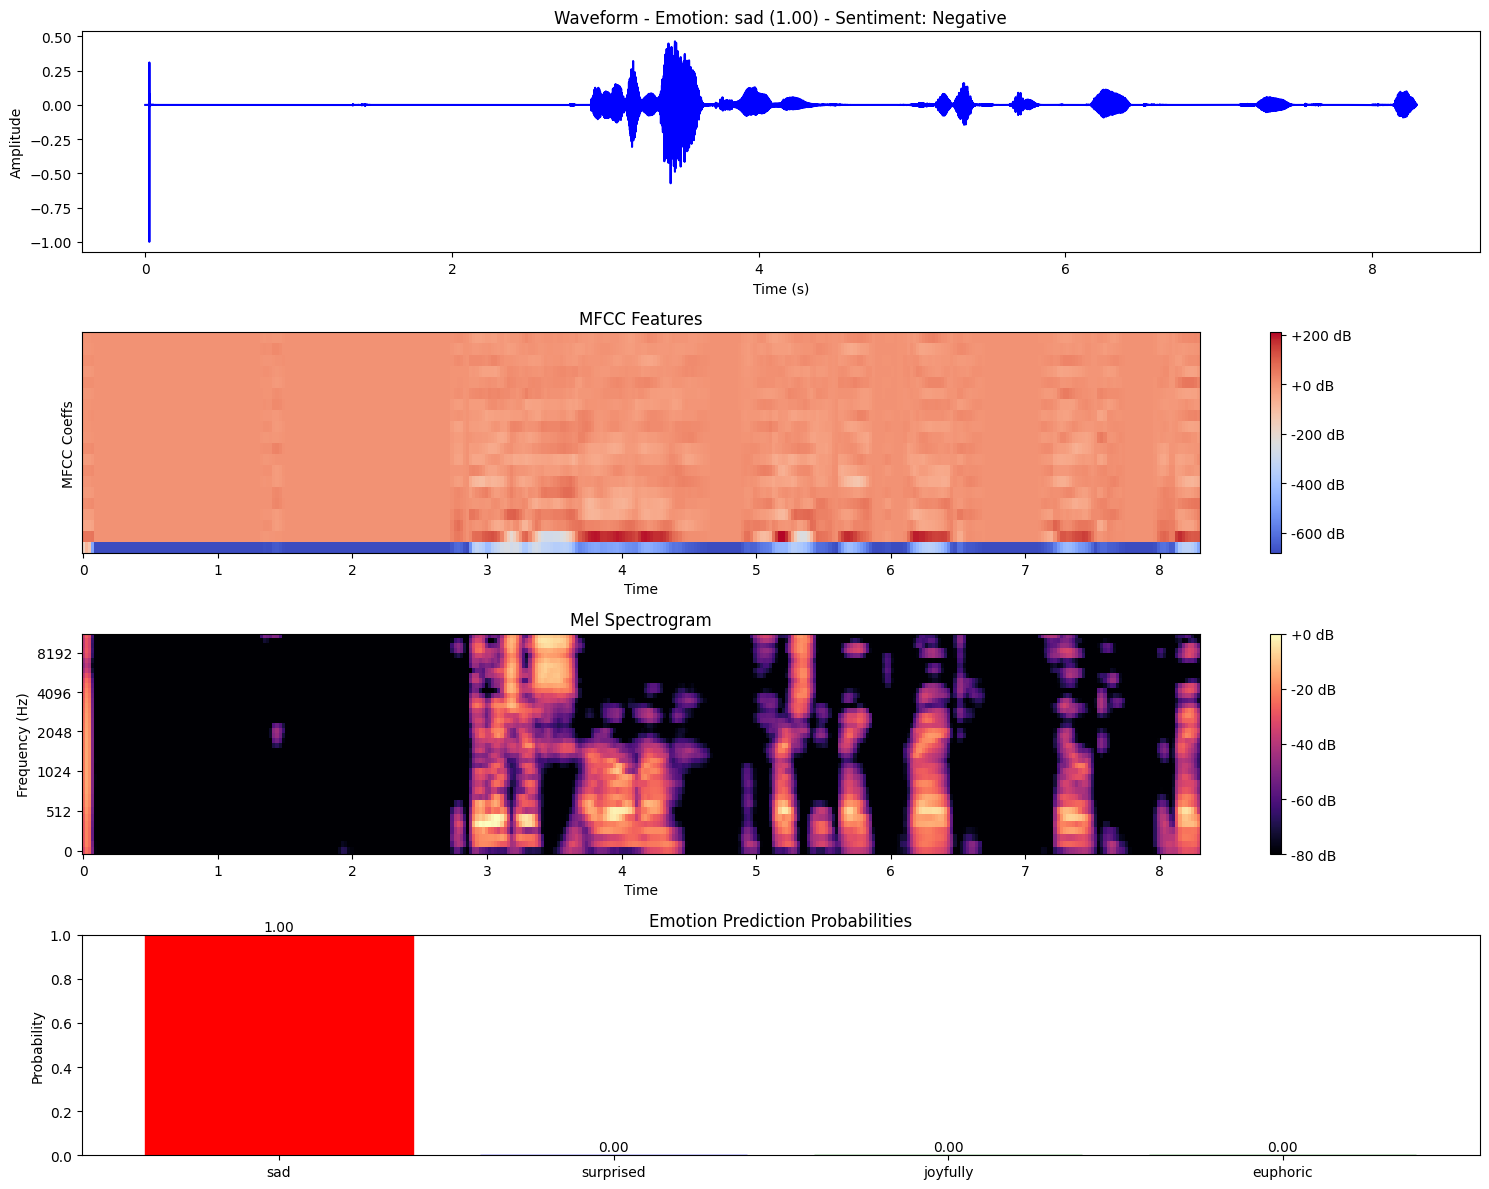

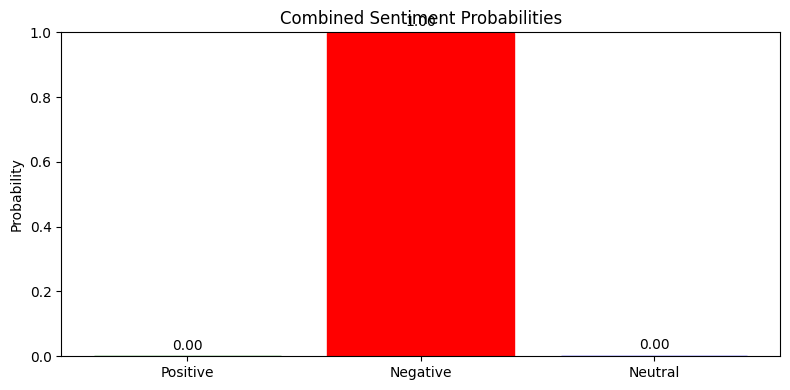

Predicted emotion: sad
Sentiment category: Negative
Confidence: 1.00

All probabilities:
  sad: 1.00
  surprised: 0.00
  joyfully: 0.00
  euphoric: 0.00

Sentiment probabilities:
  Positive: 0.00
  Negative: 1.00
  Neutral: 0.00


In [19]:
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import noisereduce as nr
import tempfile
import soundfile as sf

def reduce_noise(y, sr):
    """
    Reduces noise from an audio signal.
    
    Parameters:
    -----------
    y : numpy.ndarray
        Audio time series
    sr : int
        Sample rate of y
        
    Returns:
    --------
    y_denoised : numpy.ndarray
        Denoised audio time series
    """
    # Apply noise reduction
    y_denoised = nr.reduce_noise(y=y, sr=sr)
    
    # Normalize
    y_denoised = librosa.util.normalize(y_denoised)
    
    return y_denoised

def predict_emotion_with_sentiment(audio_file_path, model_path='speech_emotion_model_final_final.h5', show_plots=True):
    """
    Predict emotion from an audio file, map it to sentiment category, and visualize audio features.

    Parameters:
    -----------
    audio_file_path : str
        Path to the audio file to analyze
    model_path : str
        Path to the saved model file
    show_plots : bool
        Whether to display plots of audio features

    Returns:
    --------
    result : dict
        Dictionary containing:
        - emotion: The predicted emotion label
        - sentiment: The mapped sentiment category (Positive, Negative, Neutral)
        - confidence: Confidence score for the predicted emotion
        - all_probs: Dictionary with all emotion probabilities
        - sentiment_probs: Combined probabilities by sentiment category
    """
    # Define emotion labels (must match those used in training)
    emotion_labels = {
        'sad': 0,
        'surprised': 1,
        'joyfully': 2,
        'euphoric': 3
    }

    # Define sentiment mapping
    sentiment_mapping = {
        'sad': 'Negative',
        'surprised': 'Neutral',
        'joyfully': 'Positive',
        'euphoric': 'Positive'
    }

    # Reverse the dictionary for prediction output
    idx_to_emotion = {v: k for k, v in emotion_labels.items()}

    # Load the model
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    model = tf.keras.models.load_model(model_path)

    # Load and preprocess audio
    y, sr = librosa.load(audio_file_path, sr=22050)
    print("Applying noise reduction...")
    y = reduce_noise(y, sr)
    y = librosa.util.normalize(y)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    # Extract features
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)
    mfccs_normalized = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / np.std(mfccs, axis=1, keepdims=True)

    mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=40, n_fft=2048, hop_length=512, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_normalized = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)

    features = np.vstack([mfccs_normalized, mel_spec_normalized])

    # Apply same padding/cropping as in training
    max_pad_len = 150
    if features.shape[1] > max_pad_len:
        start = (features.shape[1] - max_pad_len) // 2
        features = features[:, start:start + max_pad_len]
    else:
        pad_width = max_pad_len - features.shape[1]
        features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=0)

    # Reshape features for the model
    features_for_model = features.reshape(1, features.shape[0], features.shape[1], 1)

    # Make prediction
    prediction = model.predict(features_for_model)[0]
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]
    predicted_emotion = idx_to_emotion[predicted_class]

    # Map emotion to sentiment
    predicted_sentiment = sentiment_mapping[predicted_emotion]

    # Create dictionary with all emotion probabilities
    all_probs = {idx_to_emotion[i]: float(prob) for i, prob in enumerate(prediction)}

    # Calculate sentiment probabilities (combining emotions with the same sentiment)
    sentiment_probs = {
        'Positive': sum(all_probs[e] for e, s in sentiment_mapping.items() if s == 'Positive'),
        'Negative': sum(all_probs[e] for e, s in sentiment_mapping.items() if s == 'Negative'),
        'Neutral': sum(all_probs[e] for e, s in sentiment_mapping.items() if s == 'Neutral')
    }

    # Visualize if requested
    if show_plots:
        # Create a figure with 4 subplots
        fig = plt.figure(figsize=(15, 12))

        # Plot waveform
        plt.subplot(4, 1, 1)
        plt.title(f"Waveform - Emotion: {predicted_emotion} ({confidence:.2f}) - Sentiment: {predicted_sentiment}")
        time = np.arange(0, len(y_trimmed)) / sr
        plt.plot(time, y_trimmed, color='b')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Plot MFCC
        plt.subplot(4, 1, 2)
        plt.title("MFCC Features")
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel("MFCC Coeffs")

        # Plot Mel Spectrogram
        plt.subplot(4, 1, 3)
        plt.title("Mel Spectrogram")
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel("Frequency (Hz)")

        # Plot emotion probabilities
        plt.subplot(4, 1, 4)
        bars = plt.bar(all_probs.keys(), all_probs.values())
        plt.title("Emotion Prediction Probabilities")
        plt.ylabel("Probability")
        plt.ylim(0, 1)

        # Color the bars according to sentiment
        for i, (emotion, _) in enumerate(all_probs.items()):
            if sentiment_mapping[emotion] == 'Positive':
                bars[i].set_color('green')
            elif sentiment_mapping[emotion] == 'Negative':
                bars[i].set_color('red')
            else:  # Neutral
                bars[i].set_color('blue')

        # Add probability values as text above bars
        for i, (emotion, prob) in enumerate(all_probs.items()):
            plt.text(i, prob + 0.02, f"{prob:.2f}", ha='center')

        plt.tight_layout()
        plt.show()

        # Plot sentiment probabilities separately
        plt.figure(figsize=(8, 4))
        sentiment_bars = plt.bar(sentiment_probs.keys(), sentiment_probs.values())

        # Color the sentiment bars
        for i, (sentiment, _) in enumerate(sentiment_probs.items()):
            if sentiment == 'Positive':
                sentiment_bars[i].set_color('green')
            elif sentiment == 'Negative':
                sentiment_bars[i].set_color('red')
            else:  # Neutral
                sentiment_bars[i].set_color('blue')

        plt.title("Combined Sentiment Probabilities")
        plt.ylabel("Probability")
        plt.ylim(0, 1)

        # Add probability values as text above bars
        for i, (sentiment, prob) in enumerate(sentiment_probs.items()):
            plt.text(i, prob + 0.02, f"{prob:.2f}", ha='center')

        plt.tight_layout()
        plt.show()

    # Create result dictionary
    result = {
        'emotion': predicted_emotion,
        'sentiment': predicted_sentiment,
        'confidence': float(confidence),
        'all_probs': all_probs,
        'sentiment_probs': sentiment_probs
    }

    return result

def batch_predict_with_sentiment(folder_path, model_path='speech_emotion_model_final.h5'):
    """
    Predict emotions and sentiment categories for all audio files in a folder.

    Parameters:
    -----------
    folder_path : str
        Path to folder containing audio files
    model_path : str
        Path to the saved model

    Returns:
    --------
    results : dict
        Dictionary with file names as keys and prediction results as values
    summary : dict
        Summary of emotion and sentiment counts
    """
    results = {}
    supported_formats = ['.wav', '.mp3', '.ogg', '.flac', '.amr']

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return results, {}

    print(f"Analyzing audio files in {folder_path}...")

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path) and any(file.lower().endswith(ext) for ext in supported_formats):
            print(f"Processing: {file}")
            try:
                # Use show_plots=False to avoid displaying plots for each file
                result = predict_emotion_with_sentiment(file_path, model_path, show_plots=False)
                results[file] = result
                print(f"  → Emotion: {result['emotion']} ({result['confidence']:.2f}) | Sentiment: {result['sentiment']}")
            except Exception as e:
                print(f"  → Error processing {file}: {e}")
                results[file] = {'error': str(e)}

    # Generate summary
    summary = {
        'emotions': {},
        'sentiments': {}
    }

    for file, result in results.items():
        if 'emotion' in result:
            # Count emotions
            emotion = result['emotion']
            summary['emotions'][emotion] = summary['emotions'].get(emotion, 0) + 1

            # Count sentiments
            sentiment = result['sentiment']
            summary['sentiments'][sentiment] = summary['sentiments'].get(sentiment, 0) + 1

    # Display summary
    print("\nSummary:")
    print("Emotions:")
    for emotion, count in summary['emotions'].items():
        print(f"  {emotion}: {count} files")

    print("Sentiments:")
    for sentiment, count in summary['sentiments'].items():
        print(f"  {sentiment}: {count} files")

    # Create summary visualizations
    if results:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.pie(summary['emotions'].values(), labels=summary['emotions'].keys(), autopct='%1.1f%%')
        plt.title('Emotion Distribution')

        plt.subplot(1, 2, 2)
        sentiment_bars = plt.bar(summary['sentiments'].keys(), summary['sentiments'].values())
        plt.title('Sentiment Distribution')

        # Color the sentiment bars
        for i, (sentiment, _) in enumerate(summary['sentiments'].items()):
            if sentiment == 'Positive':
                sentiment_bars[i].set_color('green')
            elif sentiment == 'Negative':
                sentiment_bars[i].set_color('red')
            else:  # Neutral
                sentiment_bars[i].set_color('blue')

        plt.tight_layout()
        plt.show()

    return results, summary

def predict_sentiment_from_microphone(duration=5, model_path='speech_emotion_model_final_final.h5', sample_rate=22050):
    """
    Record audio from microphone and predict emotion with sentiment.
    """
    try:
        import sounddevice as sd
        import soundfile as sf
        import numpy as np
        import time
        import os
        import librosa

        print(f"Recording {duration} seconds of audio...")
        audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
        sd.wait()
        audio = audio.flatten()
        
        # Play back the raw recording first
        print("Playing back raw recording...")
        sd.play(audio, sample_rate)
        sd.wait()  # Wait until playback is finished
        
        # Save original audio for comparison
        original_temp = tempfile.NamedTemporaryFile(suffix='.wav', delete=False)
        sf.write(original_temp.name, audio, sample_rate)
        print(f"Original audio saved to: {original_temp.name}")

        # Apply noise reduction 
        print("Applying noise reduction...")
        audio_processed = reduce_noise(audio, sample_rate)
        
        # Play back processed audio
        print("Playing back processed audio...")
        sd.play(audio_processed, sample_rate)
        sd.wait()
        
        # Normalize audio
        audio_processed = librosa.util.normalize(audio_processed)

        # Save processed audio
        processed_temp = tempfile.NamedTemporaryFile(suffix='.wav', delete=False)
        sf.write(processed_temp.name, audio_processed, sample_rate)
        print(f"Processed audio saved to: {processed_temp.name}")

        # Predict with sentiment
        result = predict_emotion_with_sentiment(processed_temp.name, model_path)

        print("You can compare the original and processed files manually.")
        print(f"Original: {original_temp.name}")
        print(f"Processed: {processed_temp.name}")
        
        # Don't delete files immediately to allow for comparison
        # You'll need to clean these up manually later
        
        return result

    except ImportError:
        print("This function requires sounddevice and soundfile libraries.")
        print("Install with: pip install sounddevice soundfile")
        return None
   
def realtime_sentiment_analysis(model_path='speech_emotion_model_final_final.h5', 
                               sample_rate=22050, 
                               chunk_duration=2.0,
                               buffer_duration=4.0,
                               display_window=10):
    """
    Perform real-time emotion and sentiment analysis from microphone input.
    
    Parameters:
    -----------
    model_path : str
        Path to the saved model
    sample_rate : int
        Sample rate for recording
    chunk_duration : float
        Duration of each audio chunk to process (seconds)
    buffer_duration : float
        Duration of audio to analyze at once (overlapping window)
    display_window : int
        Number of predictions to display in the trend graph
        
    Returns:
    --------
    None - runs until interrupted with Ctrl+C
    """
    try:
        import sounddevice as sd
        from collections import deque
        import time
        
        # Load the model 
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at {model_path}")
        model = tf.keras.models.load_model(model_path)
        
        # Define emotion labels and sentiment mapping
        emotion_labels = {
            'sad': 0, 'surprised': 1, 'joyfully': 2, 'euphoric': 3
        }
        idx_to_emotion = {v: k for k, v in emotion_labels.items()}
        sentiment_mapping = {
            'sad': 'Negative', 'surprised': 'Neutral', 
            'joyfully': 'Positive', 'euphoric': 'Positive'
        }
        
        # Calculate buffer sizes
        chunk_size = int(chunk_duration * sample_rate)
        buffer_size = int(buffer_duration * sample_rate)
        
        # Create a buffer for audio samples
        audio_buffer = np.zeros(buffer_size)
        
        # Deques for tracking prediction history
        emotion_history = deque(maxlen=display_window)
        sentiment_history = deque(maxlen=display_window)
        confidence_history = deque(maxlen=display_window)
        
        # Create figure for visualization
        plt.ion()  # Turn on interactive mode
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        plt.subplots_adjust(hspace=0.4)
        fig.canvas.manager.set_window_title('Real-time Emotion Analysis')
        
        # Initialize colormap for emotion bars
        emotion_colors = {'sad': 'red', 'surprised': 'blue', 
                          'joyfully': 'green', 'euphoric': 'green'}
                          
        # For continuous updates
        last_update_time = time.time()
        update_interval = 0.5  # seconds
        
        # Callback function for the audio stream
        def audio_callback(indata, frames, time_info, status):
            nonlocal audio_buffer, last_update_time
            
            if status:
                print(f"Status: {status}")
            
            # Roll the buffer and add new data
            audio_buffer = np.roll(audio_buffer, -chunk_size)
            audio_buffer[-chunk_size:] = indata[:, 0]  # Take first channel
            
            current_time = time.time()
            if current_time - last_update_time >= update_interval:
                last_update_time = current_time
                
                # Process in a non-blocking way
                process_buffer()
        
        def process_buffer():
            # Create a copy to avoid modification during processing
            buffer_copy = np.copy(audio_buffer)
            
            try:
                # Apply noise reduction
                y_denoised = reduce_noise(buffer_copy, sample_rate)
                
                # Normalize
                y_denoised = librosa.util.normalize(y_denoised)
                
                # Trim silence
                y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=20)
                if len(y_trimmed) < sample_rate * 0.5:  # At least 0.5 seconds
                    return  # Not enough vocal content
                
                # Extract features (same as in predict_emotion_with_sentiment)
                mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sample_rate, n_mfcc=20, 
                                            n_fft=2048, hop_length=512)
                mfccs_normalized = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / np.std(mfccs, axis=1, keepdims=True)
                
                mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sample_rate, n_mels=40, 
                                                         n_fft=2048, hop_length=512, fmax=8000)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                mel_spec_normalized = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)
                
                features = np.vstack([mfccs_normalized, mel_spec_normalized])
                
                # Apply same padding/cropping as in training
                max_pad_len = 150
                if features.shape[1] > max_pad_len:
                    start = (features.shape[1] - max_pad_len) // 2
                    features = features[:, start:start + max_pad_len]
                else:
                    pad_width = max_pad_len - features.shape[1]
                    features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=0)
                
                # Reshape features for the model
                features_for_model = features.reshape(1, features.shape[0], features.shape[1], 1)
                
                # Make prediction
                prediction = model.predict(features_for_model, verbose=0)[0]
                predicted_class = np.argmax(prediction)
                confidence = prediction[predicted_class]
                predicted_emotion = idx_to_emotion[predicted_class]
                predicted_sentiment = sentiment_mapping[predicted_emotion]
                
                # Update histories
                emotion_history.append(predicted_emotion)
                sentiment_history.append(predicted_sentiment)
                confidence_history.append(confidence)
                
                # Clear previous plots
                ax1.clear()
                ax2.clear()
                
                # Plot current prediction probabilities
                probabilities = {idx_to_emotion[i]: float(prob) for i, prob in enumerate(prediction)}
                emotions = list(probabilities.keys())
                values = list(probabilities.values())
                bars = ax1.bar(emotions, values)
                
                # Color the bars according to sentiment
                for i, emotion in enumerate(emotions):
                    bars[i].set_color(emotion_colors[emotion])
                
                ax1.set_ylim(0, 1)
                ax1.set_title(f'Current Prediction: {predicted_emotion} ({confidence:.2f}) - {predicted_sentiment}')
                ax1.set_ylabel('Probability')
                
                # Add probability values as text above bars
                for i, prob in enumerate(values):
                    ax1.text(i, prob + 0.02, f"{prob:.2f}", ha='center')
                
                # Plot emotion history
                if len(emotion_history) > 1:
                    # Count occurrences of each emotion in history
                    emotion_counts = {}
                    for emotion in emotion_labels.keys():
                        emotion_counts[emotion] = emotion_history.count(emotion) / len(emotion_history)
                    
                    # Count sentiment occurrences
                    sentiment_counts = {'Positive': 0, 'Negative': 0, 'Neutral': 0}
                    for emotion in emotion_history:
                        sentiment = sentiment_mapping[emotion]
                        sentiment_counts[sentiment] += 1 / len(emotion_history)
                    
                    # Plot sentiment history
                    sentiments = list(sentiment_counts.keys())
                    sent_values = list(sentiment_counts.values())
                    sent_bars = ax2.bar(sentiments, sent_values)
                    
                    # Color the sentiment bars
                    colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}
                    for i, sentiment in enumerate(sentiments):
                        sent_bars[i].set_color(colors[sentiment])
                    
                    ax2.set_ylim(0, 1)
                    ax2.set_title(f'Sentiment Trend (last {len(emotion_history)} predictions)')
                    ax2.set_ylabel('Proportion')
                    
                    # Add values as text above bars
                    for i, prob in enumerate(sent_values):
                        ax2.text(i, prob + 0.02, f"{prob:.2f}", ha='center')
                
                plt.tight_layout()
                plt.draw()
                plt.pause(0.01)
                
                # Print current prediction
                print(f"\rEmotion: {predicted_emotion:<10} Sentiment: {predicted_sentiment:<10} Confidence: {confidence:.2f}", end="")
                
            except Exception as e:
                print(f"\nError in processing: {e}")
        
        print("Starting real-time emotion analysis. Press Ctrl+C to stop.")
        
        # Start the audio stream
        with sd.InputStream(channels=1, samplerate=sample_rate, 
                           blocksize=chunk_size, callback=audio_callback):
            try:
                while True:
                    plt.pause(0.1)  # Keep UI responsive
                    
            except KeyboardInterrupt:
                print("\nStopped by user")
            finally:
                plt.close()
                
    except ImportError:
        print("This function requires sounddevice and matplotlib libraries.")
        print("Install with: pip install sounddevice matplotlib")
        return None
# Example usage
if __name__ == "__main__":
    # Basic prediction with sentiment
    audio_path = "./sad.wav"  # Replace with your audio file path

    try:
        result = predict_emotion_with_sentiment(audio_path)
        print(f"Predicted emotion: {result['emotion']}")
        print(f"Sentiment category: {result['sentiment']}")
        print(f"Confidence: {result['confidence']:.2f}")
        print("\nAll probabilities:")
        for emotion, prob in result['all_probs'].items():
            print(f"  {emotion}: {prob:.2f}")
        print("\nSentiment probabilities:")
        for sentiment, prob in result['sentiment_probs'].items():
            print(f"  {sentiment}: {prob:.2f}")
    except Exception as e:
        print(f"Error: {e}")

Starting real-time emotion analysis. Press Ctrl+C to stop.


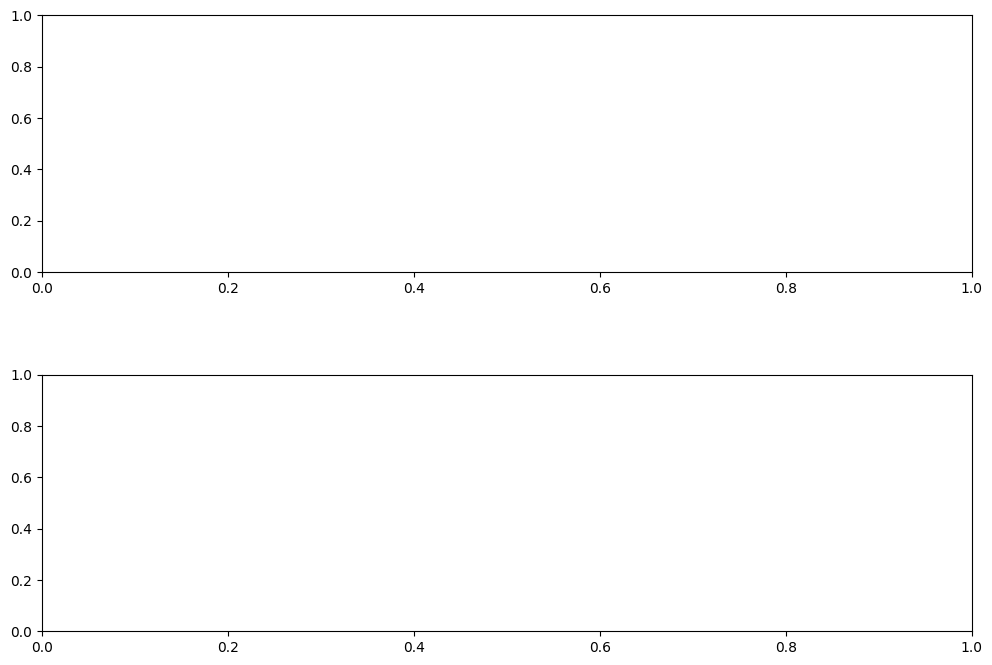

<Figure size 640x480 with 0 Axes>

Emotion: joyfully   Sentiment: Positive   Confidence: 0.51

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Emotion: sad        Sentiment: Negative   Confidence: 0.56

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.48

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.83

<Figure size 640x480 with 0 Axes>

Emotion: sad        Sentiment: Negative   Confidence: 0.58

<Figure size 640x480 with 0 Axes>

Emotion: joyfully   Sentiment: Positive   Confidence: 0.76

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.97

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.70

<Figure size 640x480 with 0 Axes>

Emotion: joyfully   Sentiment: Positive   Confidence: 0.98

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.64

<Figure size 640x480 with 0 Axes>

Emotion: sad        Sentiment: Negative   Confidence: 1.00

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Emotion: euphoric   Sentiment: Positive   Confidence: 0.98
Stopped by user


In [5]:
realtime_sentiment_analysis()

Recording 5 seconds of audio...
Playing back raw recording...
Original audio saved to: C:\Users\Ayush\AppData\Local\Temp\tmppx2rq6m1.wav
Applying noise reduction...
Playing back processed audio...


Processed audio saved to: C:\Users\Ayush\AppData\Local\Temp\tmpojhtt9hv.wav
Applying noise reduction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


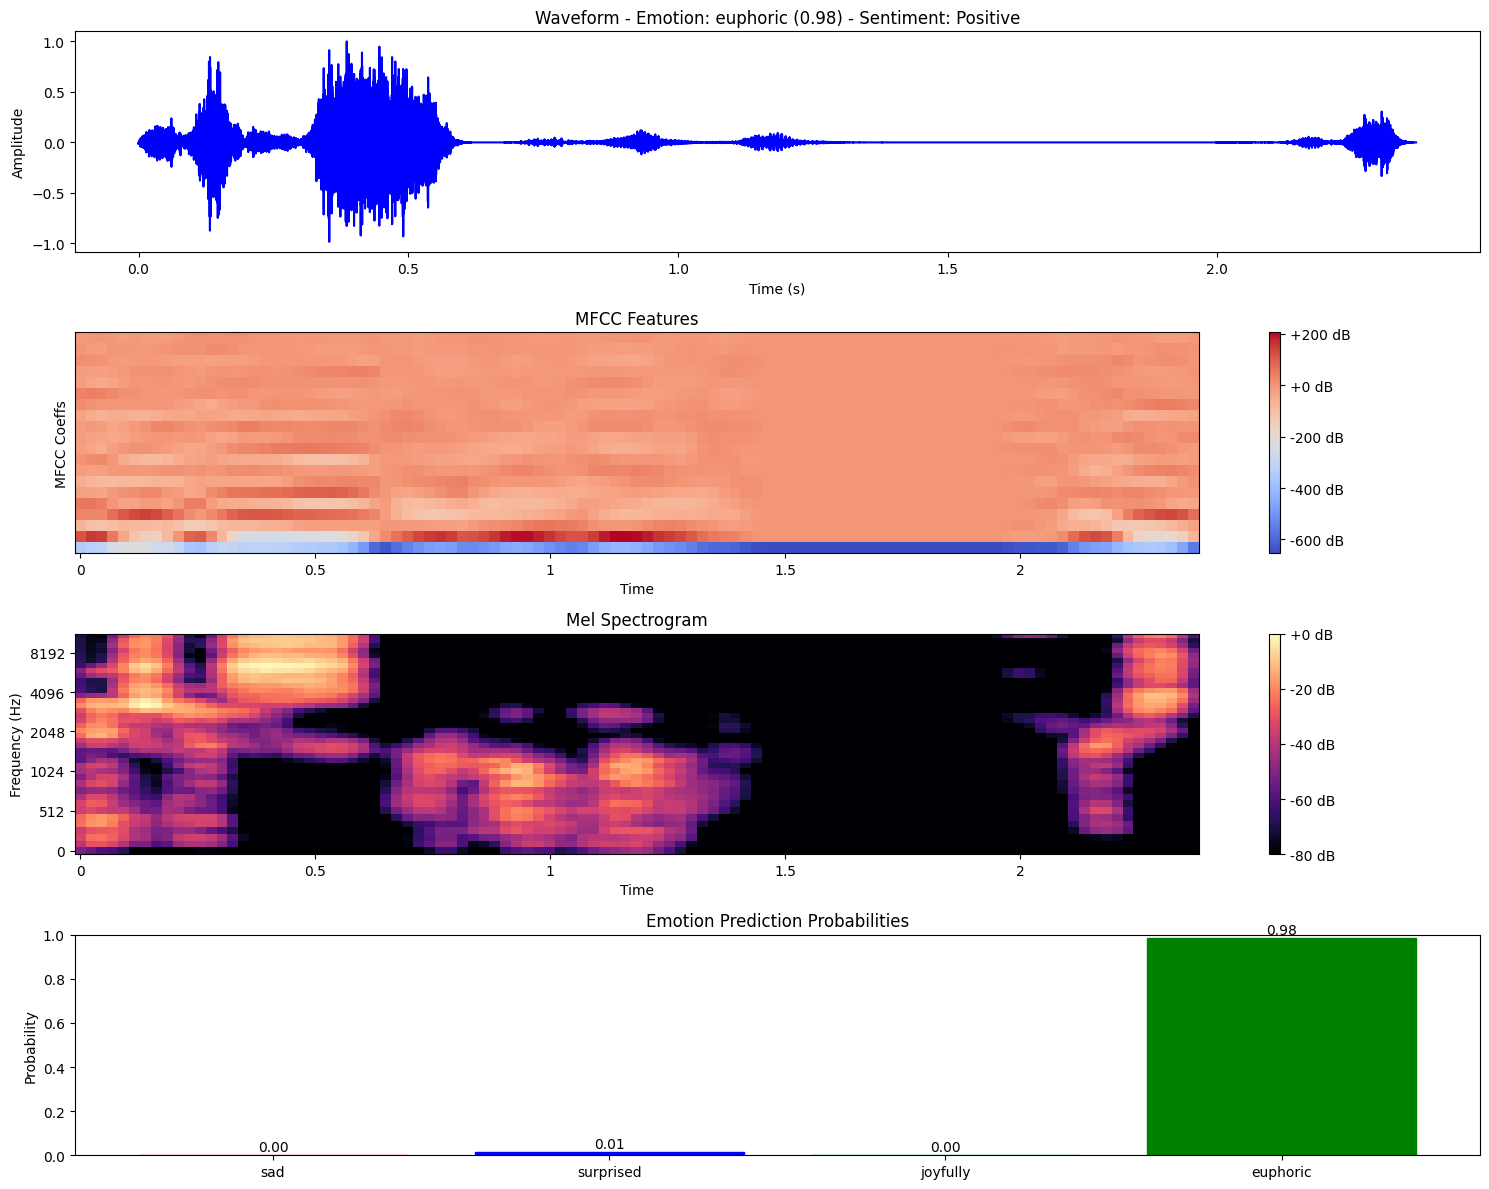

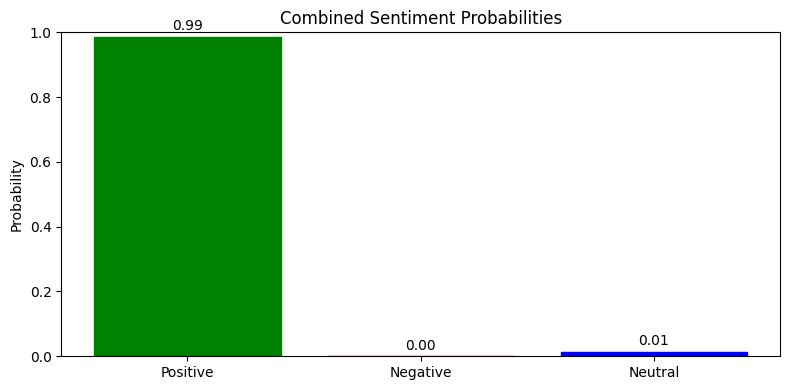

You can compare the original and processed files manually.
Original: C:\Users\Ayush\AppData\Local\Temp\tmppx2rq6m1.wav
Processed: C:\Users\Ayush\AppData\Local\Temp\tmpojhtt9hv.wav


{'emotion': 'euphoric',
 'sentiment': 'Positive',
 'confidence': 0.9848085641860962,
 'all_probs': {'sad': 4.493333108257502e-05,
  'surprised': 0.013674966990947723,
  'joyfully': 0.001471589202992618,
  'euphoric': 0.9848085641860962},
 'sentiment_probs': {'Positive': 0.9862801533890888,
  'Negative': 4.493333108257502e-05,
  'Neutral': 0.013674966990947723}}

In [22]:
predict_sentiment_from_microphone()